In [5]:
import pandas as pd
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error 
from xgboost.callback import EarlyStopping
#Carga de archivo
BASE    = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"
Df=pd.read_excel(ARCHIVO, sheet_name="DATA")
print(Df.head(2).to_string(index=False))

     Fecha  AÃ±o  Mes  Trimestre  Semana  Dia_Semana Ubicacion Producto           DescripciÃ³n  Ventas_Netas  Ventas_Brutas  Costo_Ventas  Margen_Bruto  Inventario_Total  Transacciones_Count  Precio_Promedio  Ventas_Lag_7D  Promedio_Movil_7D  Indicador_Economico_Local  Gasto_Marketing_Dia  Es_Festivo_Local  Inventario_Rotacion_Diario
2018-01-01  2018    1          1       1           0    LOC_01    Carne Carne - DÃ­a EstÃ¡ndar        412.76         472.63        273.52        139.24              2410                    7            58.97         412.76             412.76                      99.71                14.03                 0                        0.11
2018-01-01  2018    1          1       1           0    LOC_01    Pollo Pollo - DÃ­a EstÃ¡ndar        234.59         259.42        118.86        115.73              2493                    8            29.32         412.76             412.76                      99.62                 9.70                 0                     

In [3]:
Df.shape 
#Hay 143050 filas y 22 columnas, se cumple con los requerimientos del proyecto

(143050, 22)

In [4]:
Df.info() 
#Se tiene que pasar ciertas cosas a string y numeric
#El target seria las ventas Netas, para que el cliente pueda hacer analisis de demanda


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143050 entries, 0 to 143049
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Fecha                       143050 non-null  datetime64[ns]
 1   AÃ±o                        143050 non-null  int64         
 2   Mes                         143050 non-null  int64         
 3   Trimestre                   143050 non-null  int64         
 4   Semana                      143050 non-null  int64         
 5   Dia_Semana                  143050 non-null  int64         
 6   Ubicacion                   143050 non-null  object        
 7   Producto                    143050 non-null  object        
 8   DescripciÃ³n                143050 non-null  object        
 9   Ventas_Netas                143050 non-null  float64       
 10  Ventas_Brutas               143050 non-null  float64       
 11  Costo_Ventas                143050 non-

In [5]:
NewDf = Df.drop(["Transacciones_Count", "Ventas_Lag_7D", "Indicador_Economico_Local",
                 "Gasto_Marketing_Dia", "Margen_Bruto"], axis=1)

#Por los momentos, me quedare con las columnas que no elimine
print(NewDf.head(2).to_string(index=False))


     Fecha  AÃ±o  Mes  Trimestre  Semana  Dia_Semana Ubicacion Producto           DescripciÃ³n  Ventas_Netas  Ventas_Brutas  Costo_Ventas  Inventario_Total  Precio_Promedio  Promedio_Movil_7D  Es_Festivo_Local  Inventario_Rotacion_Diario
2018-01-01  2018    1          1       1           0    LOC_01    Carne Carne - DÃ­a EstÃ¡ndar        412.76         472.63        273.52              2410            58.97             412.76                 0                        0.11
2018-01-01  2018    1          1       1           0    LOC_01    Pollo Pollo - DÃ­a EstÃ¡ndar        234.59         259.42        118.86              2493            29.32             412.76                 0                        0.05


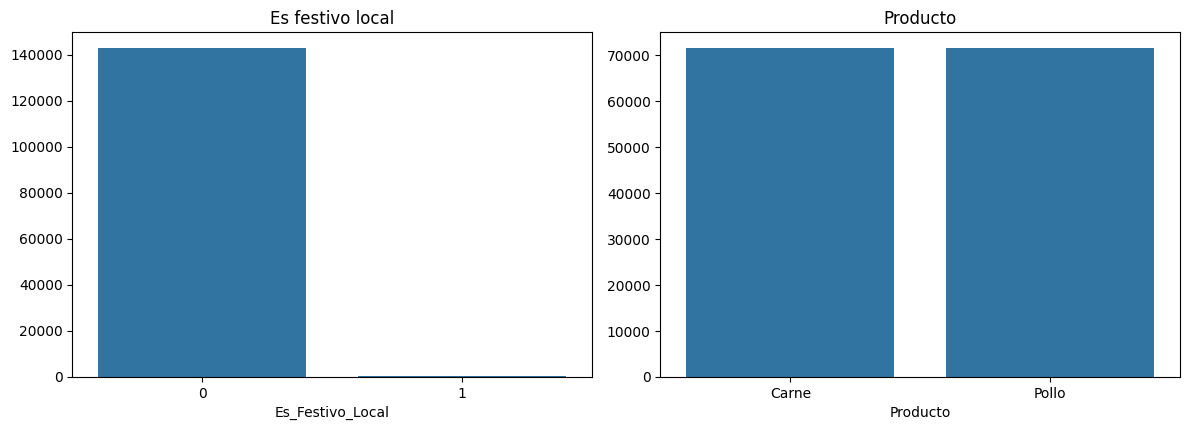

'\nAl ver el histograma, se puede ver que la mayoria del tiempo no es festivo\nPor lo que tambien podemos eliminar esta columna porque no representa mucho\n'

In [6]:
#Analsis univariate variable
#Analisis de variables categoricas, (variable que tiene un limite de numero por categoria)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(2, 2, figsize=(12, 8))

sns.countplot(ax=axis[0,0], data=NewDf, x="Es_Festivo_Local").set(ylabel=None)
axis[0,0].set_title("Es festivo local")

sns.countplot(ax=axis[0,1], data=NewDf, x="Producto").set(ylabel=None)
axis[0,1].set_title("Producto")

for ax in axis.flat[2:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()
"""
Al ver el histograma, se puede ver que la mayoria del tiempo no es festivo
Por lo que tambien podemos eliminar esta columna porque no representa mucho
"""


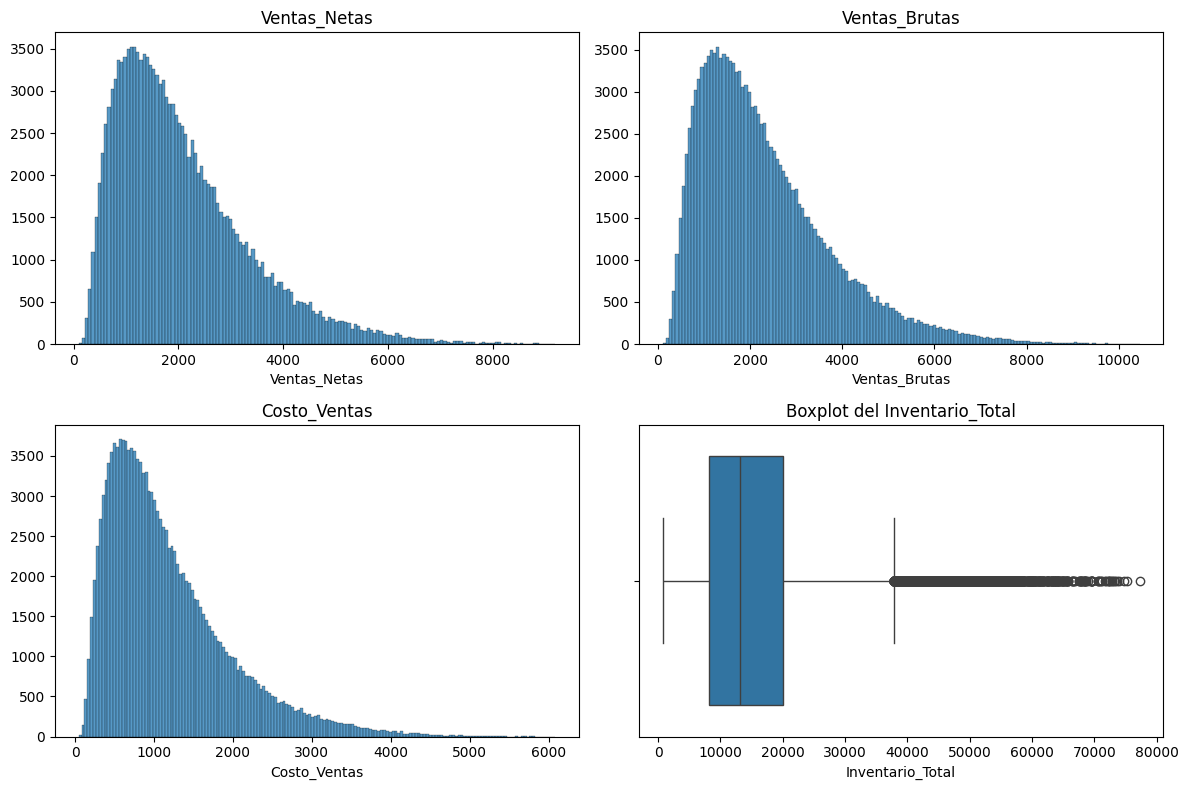

'\n\nExplicacion: Las ventas se ven en una distribucion sesgada a la derecha\npor lo que se estaria hablando de una distribucion asimetrica positiva\nel Skwe >0, el mismo caso se ve para las ventas brutas.\nMismo caso con el costo de ventas. El Inventario total tiene ciertos\noutliner, de casi 80000\n\n'

In [7]:
#Analsis de variables numericas
"""
En este caso tenemos las ventas, el costo, el inventario, etc

"""
import matplotlib.pyplot as plt
import seaborn as sns

#Crear histogramas y un diagrama de caja
fig, axis = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(ax=axis[0,0], data=NewDf, x="Ventas_Netas").set(ylabel=None)
axis[0,0].set_title("Ventas_Netas")

sns.histplot(ax=axis[0,1], data=NewDf, x="Ventas_Brutas").set(ylabel=None)
axis[0,1].set_title("Ventas_Brutas")

sns.histplot(ax=axis[1,0], data=NewDf, x="Costo_Ventas").set(ylabel=None)
axis[1,0].set_title("Costo_Ventas")


sns.boxplot(ax=axis[1,1], data= NewDf, x="Inventario_Total")
axis[1,1].set_title("Boxplot del Inventario_Total")


plt.tight_layout()
plt.show()

NewDf['Ventas_Netas'].skew()

"""

Explicacion: Las ventas se ven en una distribucion sesgada a la derecha
por lo que se estaria hablando de una distribucion asimetrica positiva
el Skwe >0, el mismo caso se ve para las ventas brutas.
Mismo caso con el costo de ventas. El Inventario total tiene ciertos
outliner, de casi 80000

"""

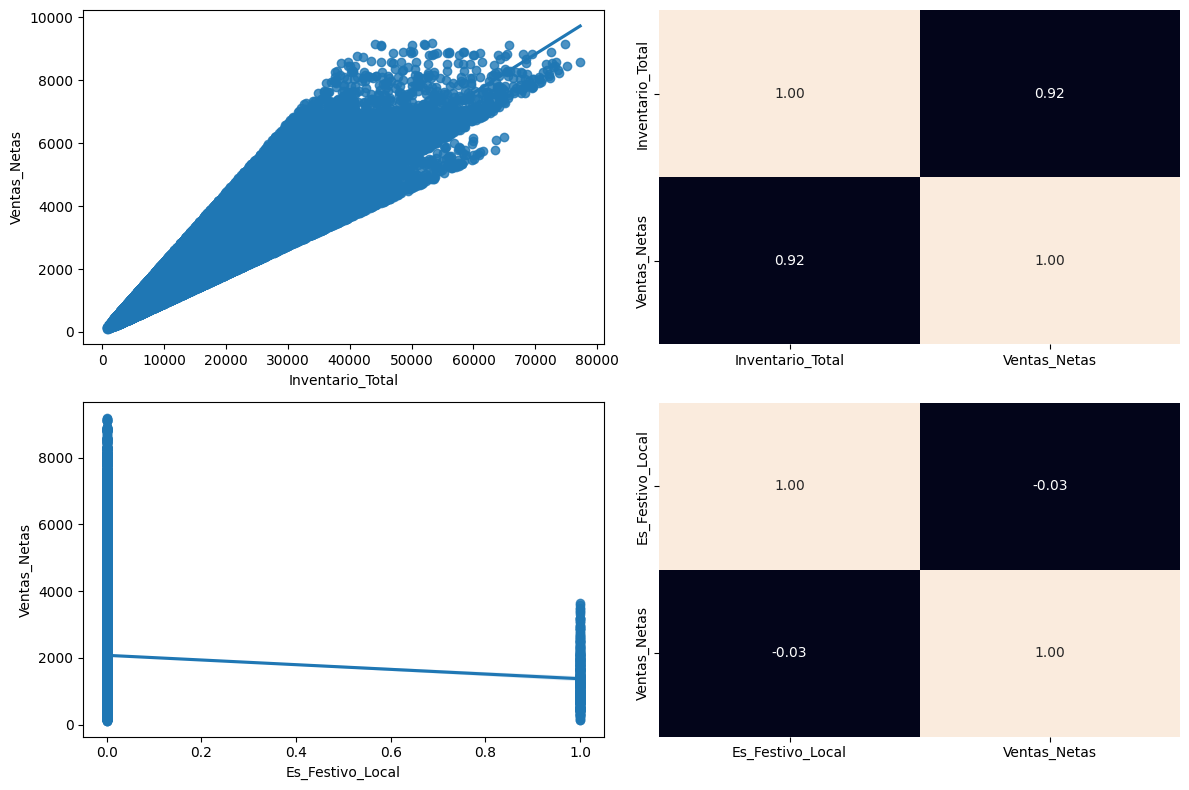

'\nLa corrlacion de las ventas y el inventario es 0.92(es muy alta)\nLa correlacion de las ventas con el festivo es -0.03(casi nula)\n'

In [8]:
#Analsis de multivariables
"""
Vamos a ver la relacion que tienen las ventas, el costo y el inventario
En este caso, lo vamos a ser numerico
"""
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(2, 2, figsize=(12, 8))

sns.regplot(ax=axis[0,0],data=NewDf, x="Inventario_Total", y="Ventas_Netas")

sns.heatmap(NewDf[["Inventario_Total","Ventas_Netas"]].corr(),annot=True,fmt=".2f",
            ax=axis[0,1], cbar=False)

sns.regplot(ax=axis[1,0],data=NewDf, x="Es_Festivo_Local", y="Ventas_Netas")

sns.heatmap(NewDf[["Es_Festivo_Local","Ventas_Netas"]].corr(),annot=True,fmt=".2f",
            ax=axis[1,1], cbar=False)


plt.tight_layout()
plt.show()
"""
Ventas e inventario estan fuertemente ligados, cuando las ventas aumentan
el inventario tambien aumenta. Sin embargo, los dias festivos no afentan 
a las ventas de forma relevante
"""
"""
La corrlacion de las ventas y el inventario es 0.92(es muy alta)
La correlacion de las ventas con el festivo es -0.03(casi nula)
"""



/var/folders/qk/0z7ssbdx0bjcfhshhz_p01_h0000gn/T/ipykernel_14215/3378462482.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


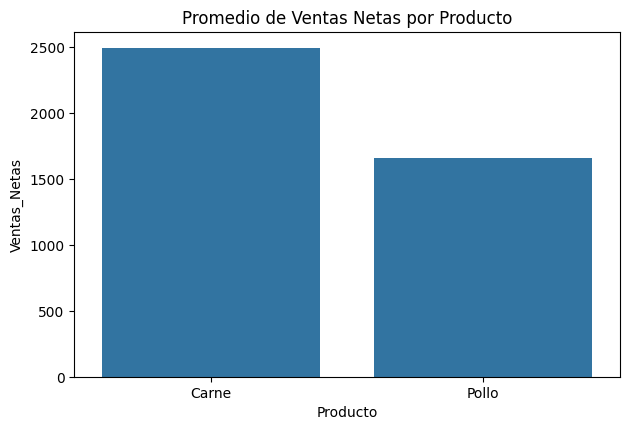

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(2, 2, figsize=(12, 8))

sns.barplot(
    ax=axis[0,0],
    data=NewDf,
    x="Producto",
    y="Ventas_Netas",
    estimator="mean",
    ci=None
)

axis[0,0].set_title("Promedio de Ventas Netas por Producto")

for ax in axis.flat[1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


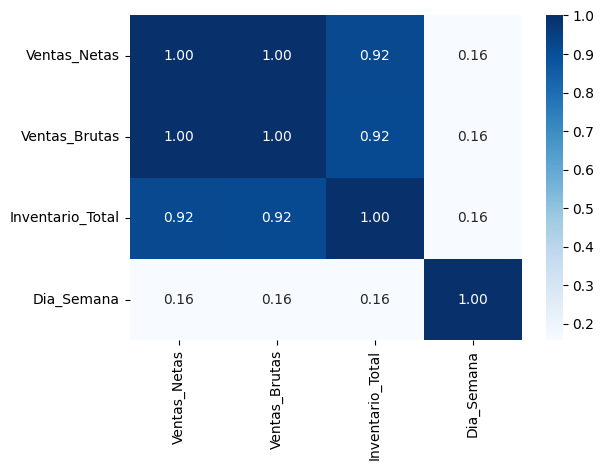

'\nNo se puede distingir una relacion clara entre las ventas y el dia\nde la semana \n\n'

In [10]:
#Numerical-categorical analysis

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(
    NewDf[["Ventas_Netas","Ventas_Brutas","Inventario_Total","Dia_Semana"]].corr(),
    annot=True,
    fmt=".2f",
    cmap="Blues"
)

plt.tight_layout()
plt.show()

"""
No se puede distingir una relacion clara entre las ventas y el dia
de la semana 

"""


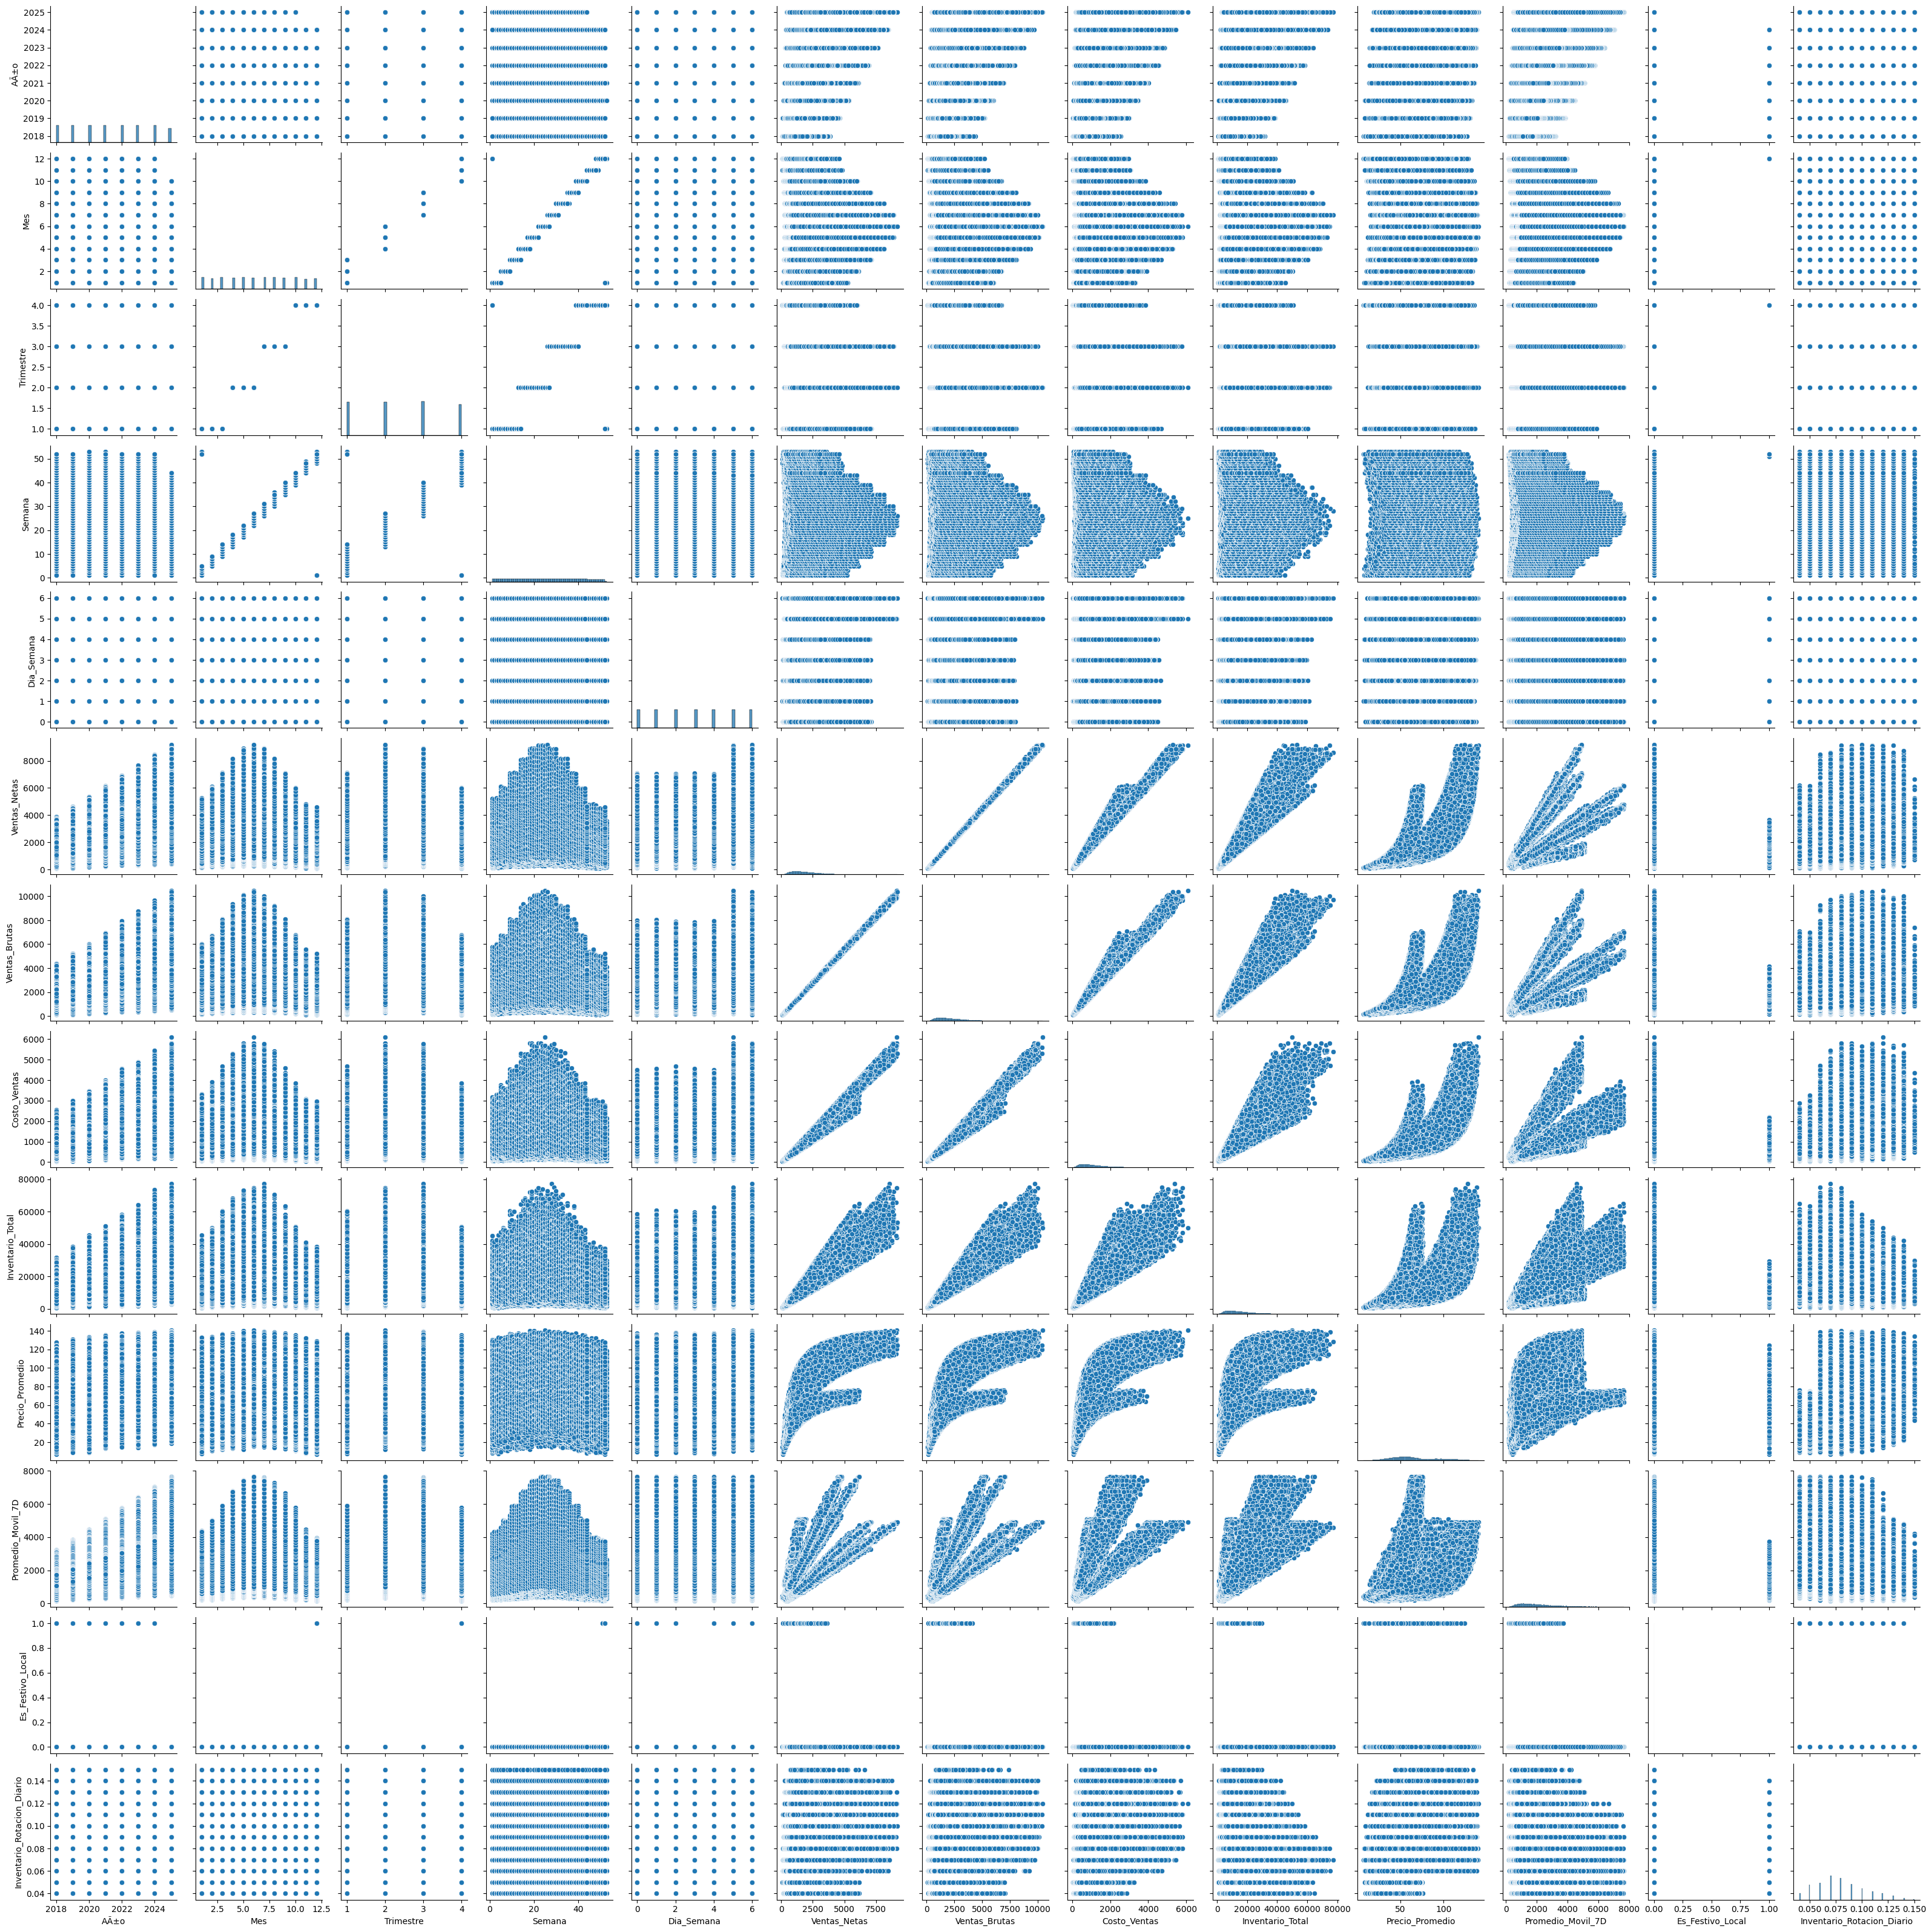

In [11]:
sns.pairplot(data=NewDf)

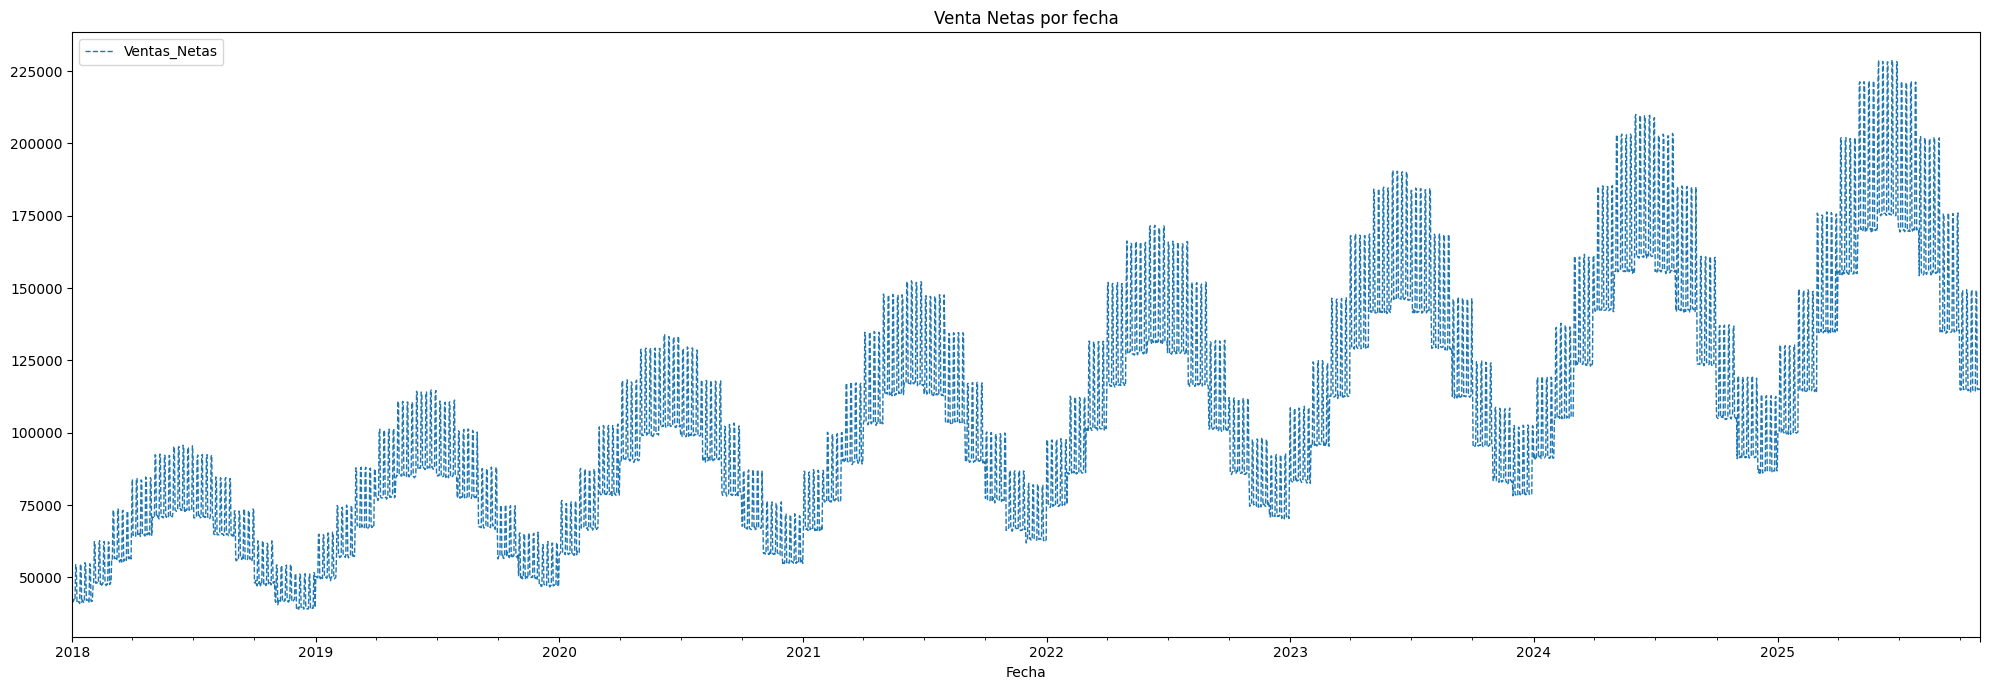

'\nLa grafica muestra una estacionalidad donde se pueden ver los picos del año, aproximadamente a mitad del año, y ademas, se puede ver que tiene \nuna tendencia creciente, tal como se muestra, esta lista para realizar un modelo de proyeccion\n\n'

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error 
from xgboost.callback import EarlyStopping
from pathlib import Path
import matplotlib.pyplot as plt


#Serie de tiempo
BASE    = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"
Df=pd.read_excel(ARCHIVO, sheet_name="DATA")
NewDf = Df.drop(["Transacciones_Count", "Ventas_Lag_7D", "Indicador_Economico_Local",
                 "Gasto_Marketing_Dia", "Margen_Bruto"], axis=1)

NewDf["Fecha"]=pd.to_datetime(NewDf["Fecha"])
counts= NewDf.groupby("Fecha")["Ventas_Netas"].sum()
pw_clean=pd.DataFrame(counts)
pw_clean["Fecha"]=pd.to_datetime(pw_clean.index)
pw_clean=pw_clean.set_index("Fecha")
pw_clean.plot(style="--",figsize=(20,7), lw=1, title="Venta Netas por fecha")
plt.tight_layout()
plt.show()
"""
La grafica muestra una estacionalidad donde se pueden ver los picos del año, aproximadamente a mitad del año, y ademas, se puede ver que tiene 
una tendencia creciente, tal como se muestra, esta lista para realizar un modelo de proyeccion

"""

[0]	validation_0-rmse:5098.15569	validation_1-rmse:7642.60887
[55]	validation_0-rmse:42.63631	validation_1-rmse:6145.01687
Fold 1 → RMSE: 6,109 | R²: 0.4758
Fold 1 → RMSE: 6,109
[0]	validation_0-rmse:5763.52946	validation_1-rmse:14688.04177
[100]	validation_0-rmse:52.33325	validation_1-rmse:7595.36727
[101]	validation_0-rmse:51.07978	validation_1-rmse:7595.46353
Fold 2 → RMSE: 7,588 | R²: 0.4770
Fold 2 → RMSE: 7,588
[0]	validation_0-rmse:7982.82813	validation_1-rmse:13386.05684
[100]	validation_0-rmse:83.30074	validation_1-rmse:6134.68549
[111]	validation_0-rmse:74.83689	validation_1-rmse:6134.53986
Fold 3 → RMSE: 6,129 | R²: 0.7443
Fold 3 → RMSE: 6,129
[0]	validation_0-rmse:9027.96932	validation_1-rmse:20911.81242
[100]	validation_0-rmse:113.23584	validation_1-rmse:7343.32675
[200]	validation_0-rmse:52.23968	validation_1-rmse:7324.28614
[225]	validation_0-rmse:43.91520	validation_1-rmse:7325.87053
Fold 4 → RMSE: 7,322 | R²: 0.7299
Fold 4 → RMSE: 7,322

RMSE por fold: ['6,109', '7,588'

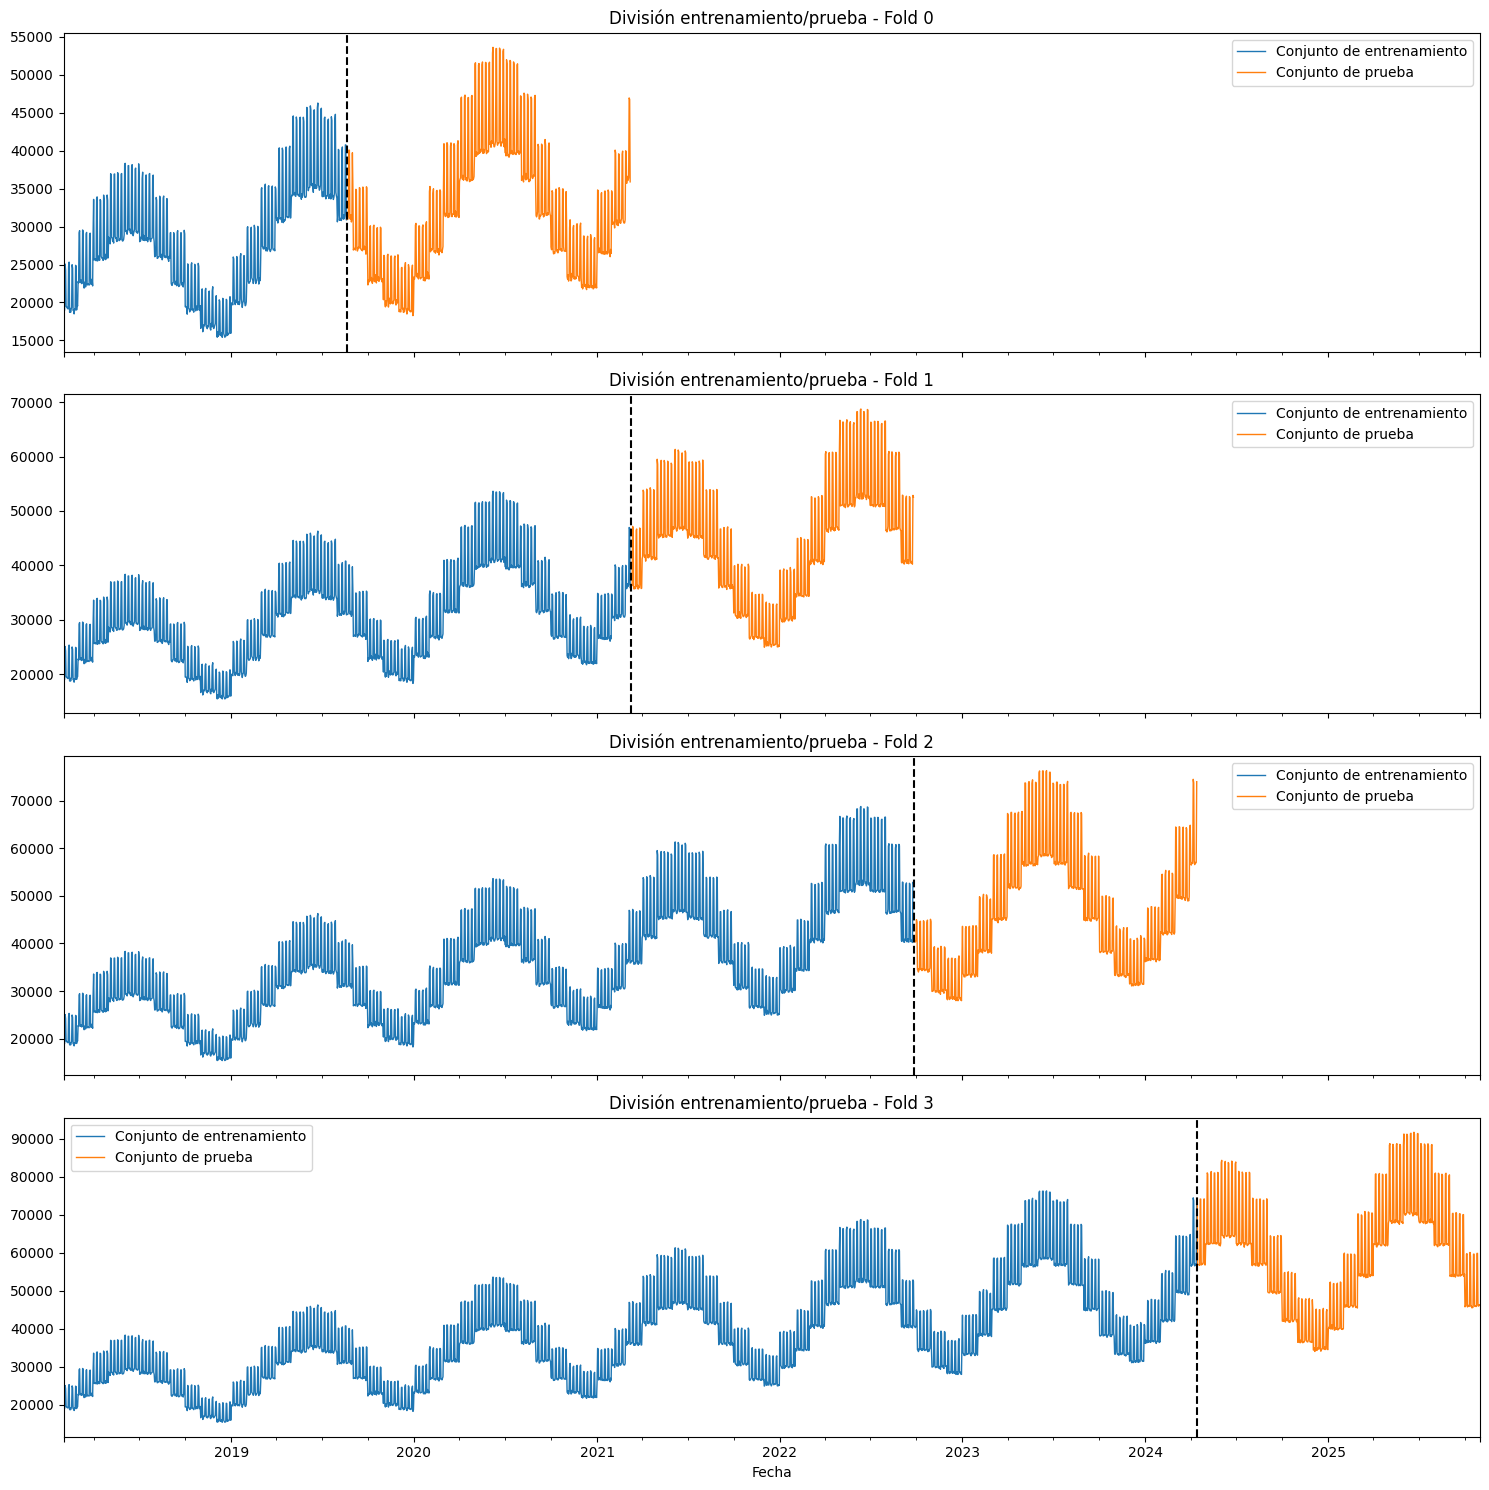

In [7]:
import pandas as pd
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error 
from xgboost.callback import EarlyStopping
from sklearn.metrics import r2_score


BASE    = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"
Df=pd.read_excel(ARCHIVO, sheet_name="DATA")
NewDf = Df.drop(["Transacciones_Count", "Ventas_Lag_7D", "Indicador_Economico_Local",
                 "Gasto_Marketing_Dia", "Margen_Bruto"], axis=1)

#Modelo del pollo
NewDf["Fecha"]=pd.to_datetime(NewDf["Fecha"])
NewDf=NewDf[NewDf["Producto"]=="Pollo"]
counts= NewDf.groupby("Fecha")["Ventas_Netas"].sum()
pw_clean=pd.DataFrame(counts)
pw_clean["Fecha"]=pd.to_datetime(pw_clean.index)
pw_clean=pw_clean.set_index("Fecha")

# crear los atributos de las fechas
def  create_attributes ( df ): 
    df = df.copy() 
    df[ 'día' ] = df.index.day 
    df[ 'díadelasemana' ] = df.index.dayofweek 
    df[ 'mes' ] = df.index.month 
    df[ 'trimestre' ] = df.index.quarter 
    df[ 'año' ] = df.index.year 
    df[ 'díadelaño' ] = df.index.dayofyear 
    return df 

def add_lag_features(df, target='Ventas_Netas', lags=[1,7,14,30]):
    df = df.copy()
    for lag in lags:
        df[f'{target}_lag{lag}'] = df[target].shift(lag)
    df[f'{target}_rolling7']  = df[target].shift(1).rolling(7).mean()
    df[f'{target}_rolling30'] = df[target].shift(1).rolling(30).mean()
    return df

pw_clean= create_attributes(pw_clean)
pw_clean = add_lag_features(pw_clean)
pw_clean = pw_clean.dropna()

pw_clean = pw_clean.sort_index()

ts_cv = TimeSeriesSplit(n_splits=4
                        )
fold = 0
preds = []
scores = []
r2_scores = []

for train_idx, val_idx in ts_cv.split(pw_clean):
    fold += 1
    train = pw_clean.iloc[train_idx].copy()
    test  = pw_clean.iloc[val_idx].copy()

    train = create_attributes(train)
    test  = create_attributes(test)

    features = ['día', 'díadelasemana', 'mes', 'trimestre', 'año', 'díadelaño']
    target = 'Ventas_Netas'

    x_train = train[features]
    y_train = train[target].values.ravel()  
    x_test  = test[features]
    y_test  = test[target].values.ravel()   

    # hiperparámetros
    xgb_reg = xgb.XGBRegressor(
    booster='gbtree',
    random_state=42,
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.3,  
    reg_lambda=0.001,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50  
)
    xgb_reg.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=100
)
    #METRICAS
    y_pred = xgb_reg.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)
    preds.append(y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    print(f"Fold {fold} → RMSE: {rmse:,.0f} | R²: {r2:.4f}")


   
    print(f"Fold {fold} → RMSE: {rmse:,.0f}")

print("\nRMSE por fold:", [f"{s:,.0f}" for s in scores])
print(f"RMSE promedio: {np.mean(scores):,.0f}")
print(f"R² promedio: {np.mean(r2_scores):.4f}")





fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True) 
fold = 0
for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test  = pw_clean.iloc[val_idx]

    train["Ventas_Netas"].plot(ax=axs[fold], lw=1, label="Conjunto de entrenamiento")
    test["Ventas_Netas"].plot(ax=axs[fold], lw=1, label="Conjunto de prueba")
    axs[fold].axvline(test.index.min(), color="black", ls="--") 
    axs[fold].set_title(f"División entrenamiento/prueba - Fold {fold}") 
    axs[fold].legend()
    fold += 1

plt.tight_layout()
plt.show()

[0]	validation_0-rmse:4068.18139	validation_1-rmse:7466.52441
[99]	validation_0-rmse:0.00244	validation_1-rmse:5077.43035
Fold 1 → RMSE: 5,077 | R²: 0.5181
Fold 1 → RMSE: 5,077
[0]	validation_0-rmse:4936.57137	validation_1-rmse:9383.39965
[100]	validation_0-rmse:0.00305	validation_1-rmse:5147.15013
[108]	validation_0-rmse:0.00305	validation_1-rmse:5147.15013
Fold 2 → RMSE: 5,147 | R²: 0.7205
Fold 2 → RMSE: 5,147
[0]	validation_0-rmse:5966.84706	validation_1-rmse:9767.39945
[94]	validation_0-rmse:0.00271	validation_1-rmse:4791.23870
Fold 3 → RMSE: 4,791 | R²: 0.7960
Fold 3 → RMSE: 4,791
[0]	validation_0-rmse:6667.82904	validation_1-rmse:9552.11232
[57]	validation_0-rmse:0.03030	validation_1-rmse:5243.55131
Fold 4 → RMSE: 5,182 | R²: 0.7347
Fold 4 → RMSE: 5,182
[0]	validation_0-rmse:7112.71617	validation_1-rmse:11124.23393
[100]	validation_0-rmse:0.00305	validation_1-rmse:3939.85238
[101]	validation_0-rmse:0.00304	validation_1-rmse:3939.85224
Fold 5 → RMSE: 3,940 | R²: 0.8621
Fold 5 → RM

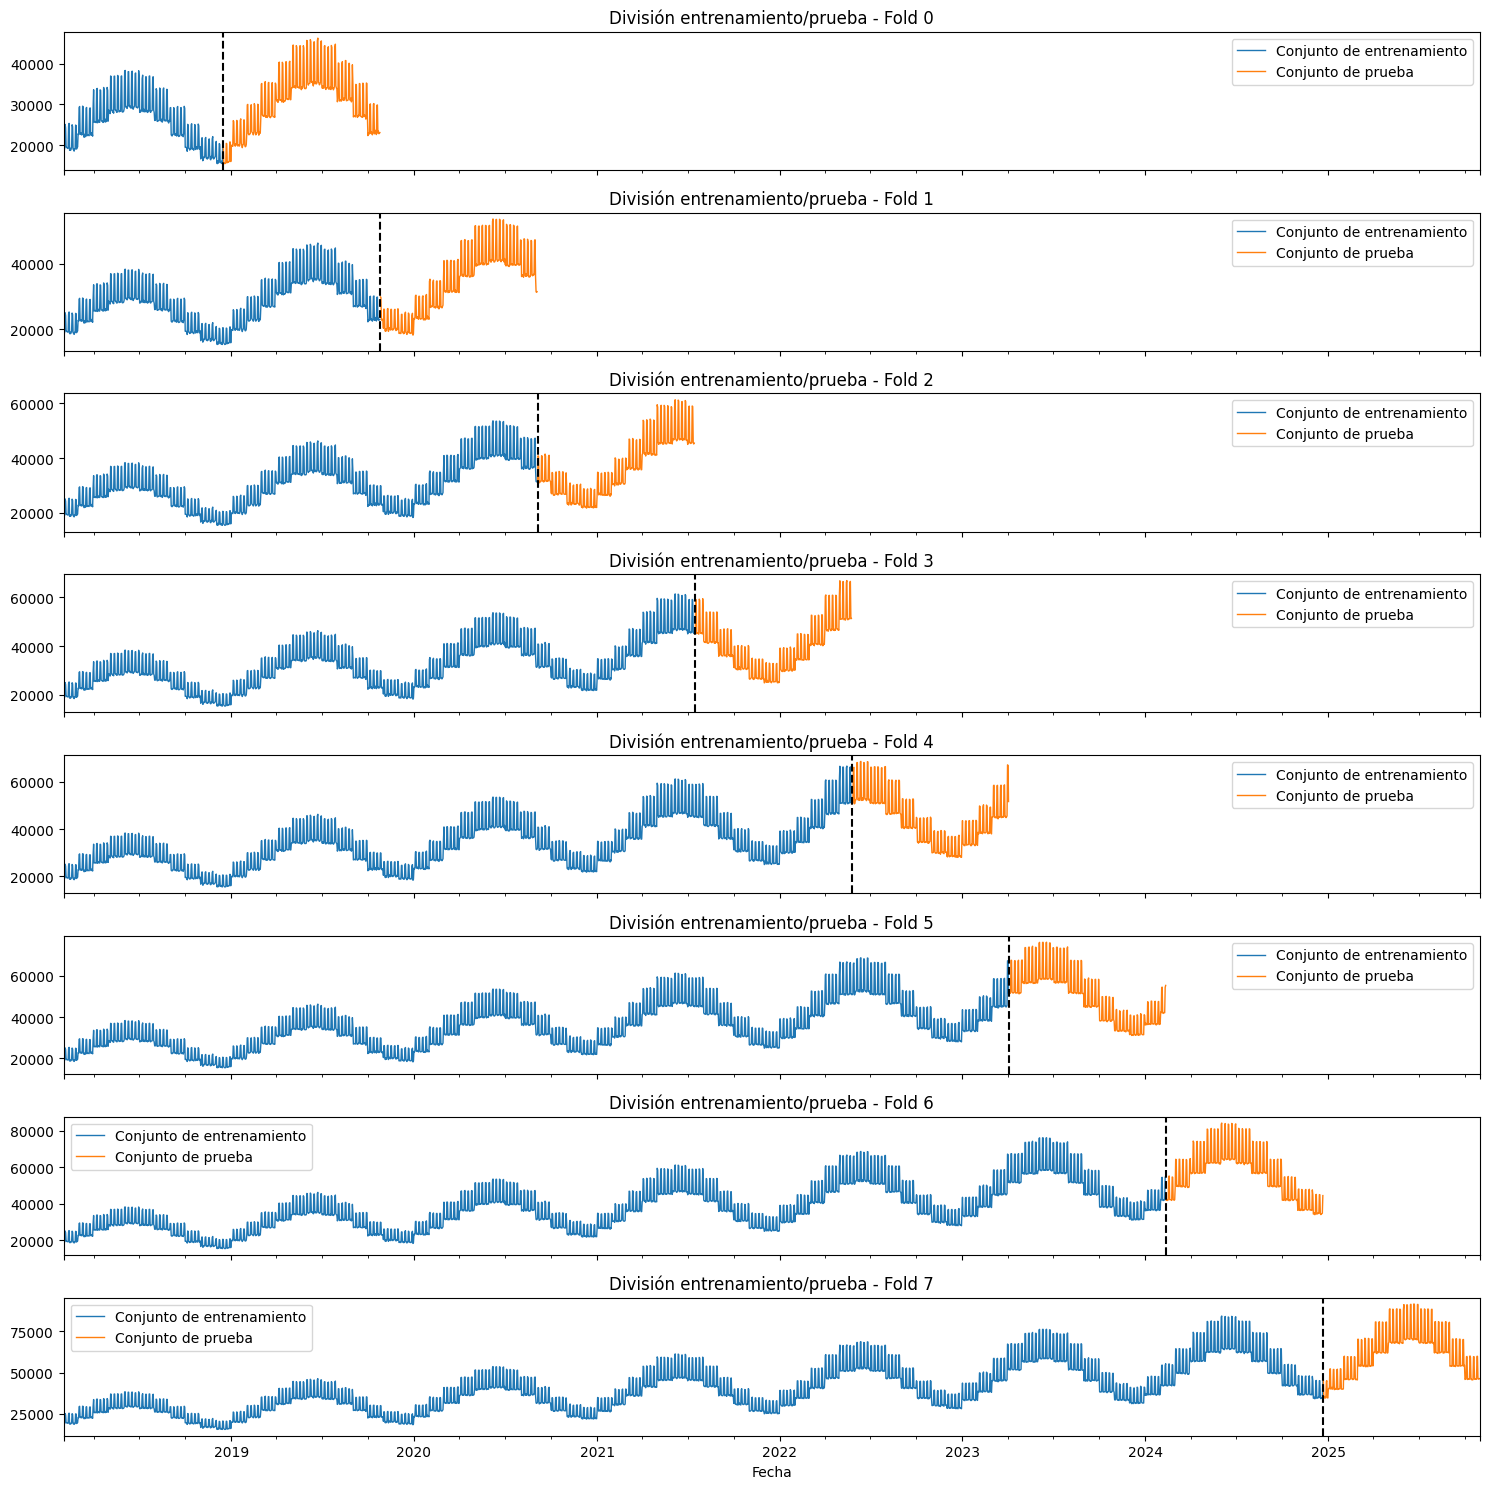

In [8]:
#Ahora vamos a cambiarle los hiperparametros para saber si hay una mejora con el R2 debido que el primero fue 0.6
#el cual, no es malo, pero se puede mejorar
import pandas as pd
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error 
from xgboost.callback import EarlyStopping
from sklearn.metrics import r2_score

BASE = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"
Df=pd.read_excel(ARCHIVO, sheet_name="DATA")
NewDf = Df.drop(["Transacciones_Count", "Ventas_Lag_7D", "Indicador_Economico_Local",
                 "Gasto_Marketing_Dia", "Margen_Bruto"], axis=1)

#Modelo del pollo
NewDf["Fecha"]=pd.to_datetime(NewDf["Fecha"])
NewDf=NewDf[NewDf["Producto"]=="Pollo"]
counts= NewDf.groupby("Fecha")["Ventas_Netas"].sum()
pw_clean=pd.DataFrame(counts)
pw_clean["Fecha"]=pd.to_datetime(pw_clean.index)
pw_clean=pw_clean.set_index("Fecha")

# crear los atributos de las fechas
def  create_attributes ( df ): 
    df = df.copy() 
    df[ 'día' ] = df.index.day 
    df[ 'díadelasemana' ] = df.index.dayofweek 
    df[ 'mes' ] = df.index.month 
    df[ 'trimestre' ] = df.index.quarter 
    df[ 'año' ] = df.index.year 
    df[ 'díadelaño' ] = df.index.dayofyear 
    return df 

def add_lag_features(df, target='Ventas_Netas', lags=[1,7,14,30]):
    df = df.copy()
    for lag in lags:
        df[f'{target}_lag{lag}'] = df[target].shift(lag)
    df[f'{target}_rolling7']  = df[target].shift(1).rolling(7).mean()
    df[f'{target}_rolling30'] = df[target].shift(1).rolling(30).mean()
    return df

pw_clean= create_attributes(pw_clean)
pw_clean = add_lag_features(pw_clean)
pw_clean = pw_clean.dropna()

pw_clean = pw_clean.sort_index()

ts_cv = TimeSeriesSplit(n_splits=8
                        )
fold = 0
preds = []
scores = []
r2_scores = []

for train_idx, val_idx in ts_cv.split(pw_clean):
    fold += 1
    train = pw_clean.iloc[train_idx].copy()
    test  = pw_clean.iloc[val_idx].copy()

    train = create_attributes(train)
    test  = create_attributes(test)

    features = ['día', 'díadelasemana', 'mes', 'trimestre', 'año', 'díadelaño']
    target = 'Ventas_Netas'

    x_train = train[features]
    y_train = train[target].values.ravel()  
    x_test  = test[features]
    y_test  = test[target].values.ravel()   

    # hiperparámetros
    xgb_reg = xgb.XGBRegressor(
    booster='gbtree',
    random_state=42,
    n_estimators=1000,
    max_depth=12,
    learning_rate=0.3,  
    reg_lambda=0.001,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50  
)
    xgb_reg.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=100
)
    #METRICAS
    y_pred = xgb_reg.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)
    preds.append(y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    print(f"Fold {fold} → RMSE: {rmse:,.0f} | R²: {r2:.4f}")


   
    print(f"Fold {fold} → RMSE: {rmse:,.0f}")

print("\nRMSE por fold:", [f"{s:,.0f}" for s in scores])
print(f"RMSE promedio: {np.mean(scores):,.0f}")
print(f"R² promedio: {np.mean(r2_scores):.4f}")





fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True) 
fold = 0
for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test  = pw_clean.iloc[val_idx]

    train["Ventas_Netas"].plot(ax=axs[fold], lw=1, label="Conjunto de entrenamiento")
    test["Ventas_Netas"].plot(ax=axs[fold], lw=1, label="Conjunto de prueba")
    axs[fold].axvline(test.index.min(), color="black", ls="--") 
    axs[fold].set_title(f"División entrenamiento/prueba - Fold {fold}") 
    axs[fold].legend()
    fold += 1

plt.tight_layout()
plt.show()

[0]	validation_0-rmse:6113.52195	validation_1-rmse:11166.38451
[100]	validation_0-rmse:0.00358	validation_1-rmse:7566.07194
[105]	validation_0-rmse:0.00358	validation_1-rmse:7566.07194
Fold 1 → RMSE: 7,566 | R²: 0.5215
Fold 1 → RMSE: 7,566
[0]	validation_0-rmse:7395.65028	validation_1-rmse:14075.94904
[100]	validation_0-rmse:0.00425	validation_1-rmse:7712.43414
[200]	validation_0-rmse:0.00425	validation_1-rmse:7712.43080
[300]	validation_0-rmse:0.00425	validation_1-rmse:7712.42745
[400]	validation_0-rmse:0.00425	validation_1-rmse:7712.42410
[500]	validation_0-rmse:0.00425	validation_1-rmse:7712.42076
[600]	validation_0-rmse:0.00425	validation_1-rmse:7712.41741
[700]	validation_0-rmse:0.00425	validation_1-rmse:7712.41407
[800]	validation_0-rmse:0.00425	validation_1-rmse:7712.41073
[900]	validation_0-rmse:0.00425	validation_1-rmse:7712.40738
[999]	validation_0-rmse:0.00425	validation_1-rmse:7712.40407
Fold 2 → RMSE: 7,712 | R²: 0.7213
Fold 2 → RMSE: 7,712
[0]	validation_0-rmse:8945.12513

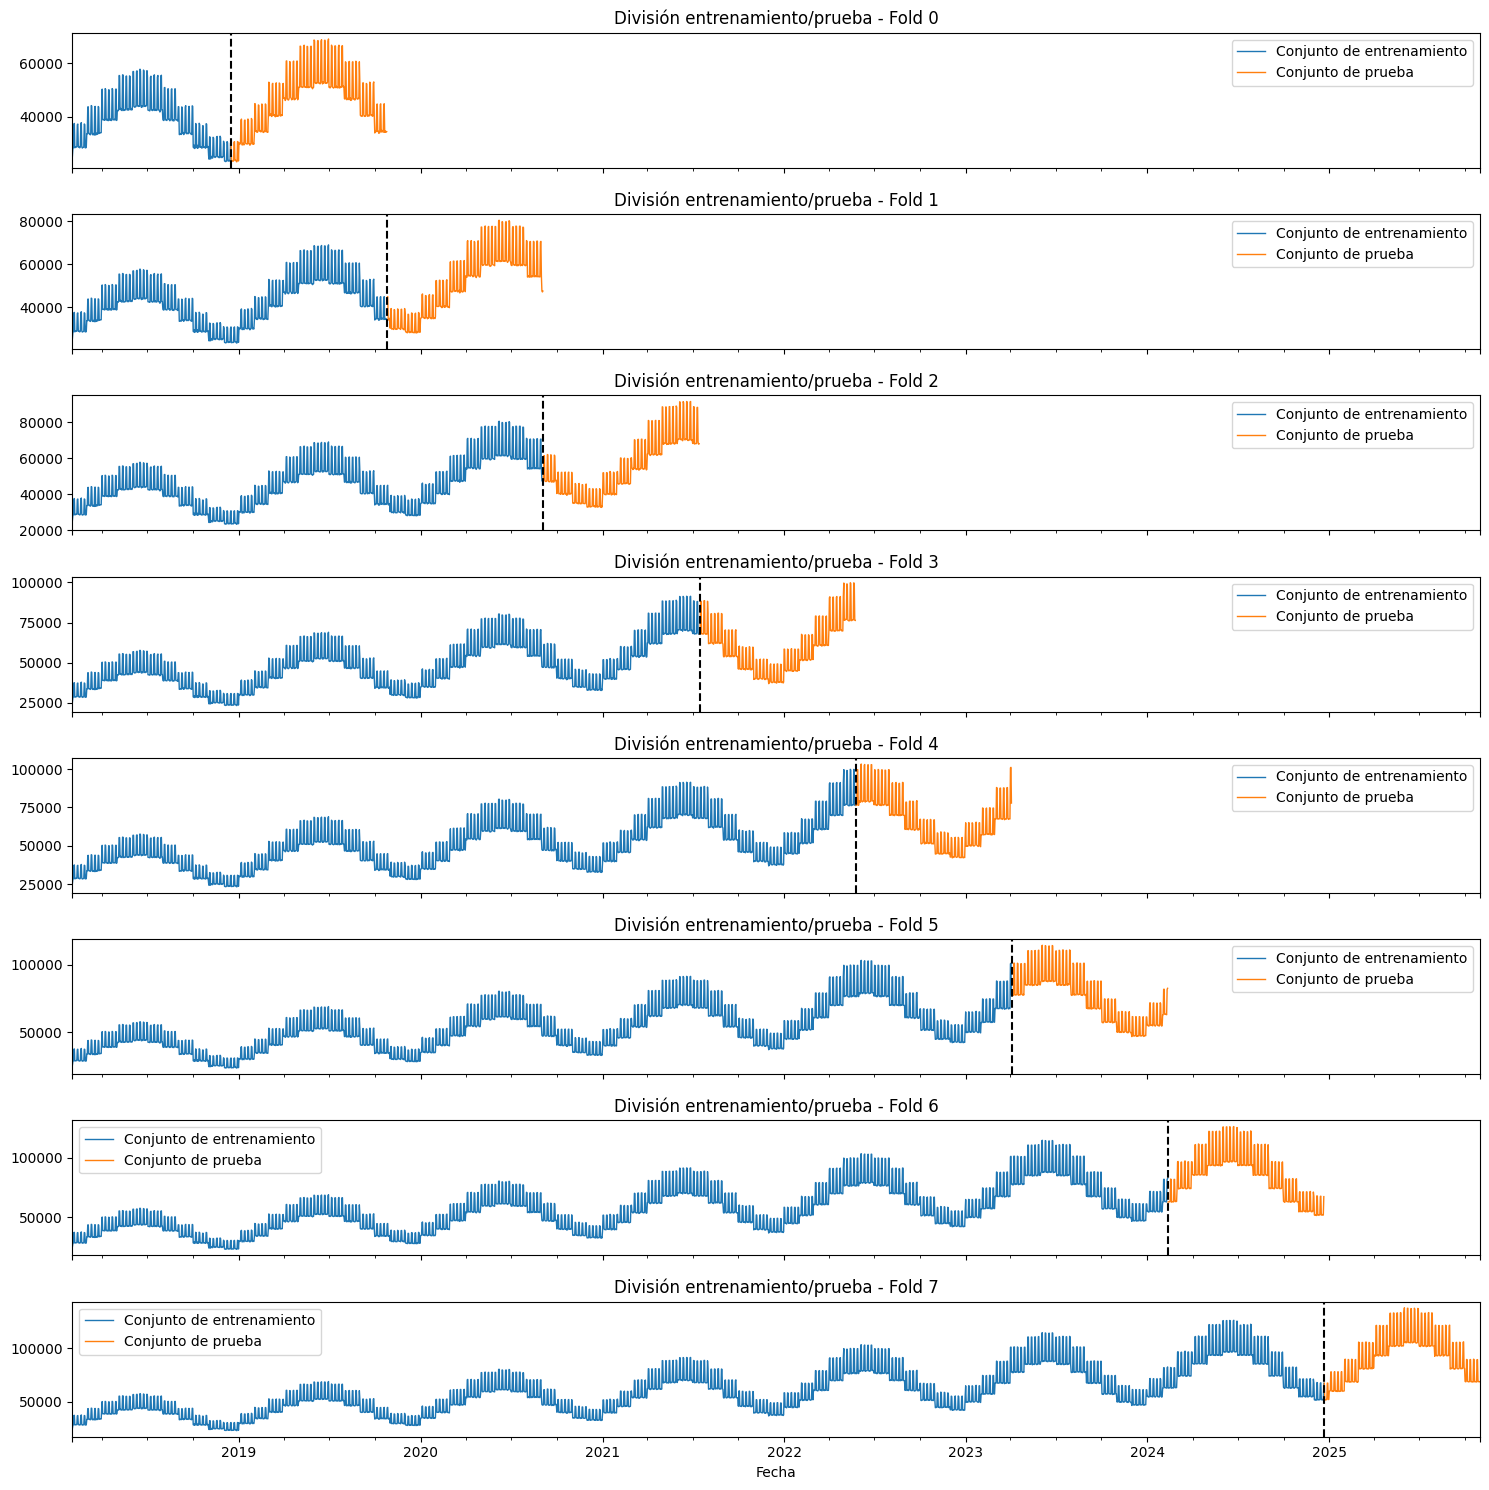

In [9]:
#Ahora vamos a cambiarle los hiperparametros para saber si hay una mejora con el R2 debido que el primero fue 0.6
#el cual, no es malo, pero se puede mejorar
import pandas as pd
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error 
from xgboost.callback import EarlyStopping
#Carga de archivo
BASE    = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"
Df=pd.read_excel(ARCHIVO, sheet_name="DATA")
NewDf = Df.drop(["Transacciones_Count", "Ventas_Lag_7D", "Indicador_Economico_Local",
                "Gasto_Marketing_Dia", "Margen_Bruto"], axis=1)

#Modelo del pollo
NewDf["Fecha"]=pd.to_datetime(NewDf["Fecha"])
NewDf=NewDf[NewDf["Producto"]=="Carne"]
counts= NewDf.groupby("Fecha")["Ventas_Netas"].sum()
pw_clean=pd.DataFrame(counts)
pw_clean["Fecha"]=pd.to_datetime(pw_clean.index)
pw_clean=pw_clean.set_index("Fecha")

# crear los atributos de las fechas
def  create_attributes ( df ): 
    df = df.copy() 
    df[ 'día' ] = df.index.day 
    df[ 'díadelasemana' ] = df.index.dayofweek 
    df[ 'mes' ] = df.index.month 
    df[ 'trimestre' ] = df.index.quarter 
    df[ 'año' ] = df.index.year 
    df[ 'díadelaño' ] = df.index.dayofyear 
    return df 

def add_lag_features(df, target='Ventas_Netas', lags=[1,7,14,30]):
    df = df.copy()
    for lag in lags:
        df[f'{target}_lag{lag}'] = df[target].shift(lag)
    df[f'{target}_rolling7']  = df[target].shift(1).rolling(7).mean()
    df[f'{target}_rolling30'] = df[target].shift(1).rolling(30).mean()
    return df

pw_clean= create_attributes(pw_clean)
pw_clean = add_lag_features(pw_clean)
pw_clean = pw_clean.dropna()

pw_clean = pw_clean.sort_index()

ts_cv = TimeSeriesSplit(n_splits=8
                        )
fold = 0
preds = []
scores = []
r2_scores = []

for train_idx, val_idx in ts_cv.split(pw_clean):
    fold += 1
    train = pw_clean.iloc[train_idx].copy()
    test  = pw_clean.iloc[val_idx].copy()

    train = create_attributes(train)
    test  = create_attributes(test)

    features = ['día', 'díadelasemana', 'mes', 'trimestre', 'año', 'díadelaño']
    target = 'Ventas_Netas'

    x_train = train[features]
    y_train = train[target].values.ravel()  
    x_test  = test[features]
    y_test  = test[target].values.ravel()   

    # hiperparámetros
    xgb_reg = xgb.XGBRegressor(
    booster='gbtree',
    random_state=42,
    n_estimators=1000,
    max_depth=12,
    learning_rate=0.3,  
    reg_lambda=0.001,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50  
)
    xgb_reg.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=100
)
    #METRICAS
    y_pred = xgb_reg.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)
    preds.append(y_pred)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    print(f"Fold {fold} → RMSE: {rmse:,.0f} | R²: {r2:.4f}")



    print(f"Fold {fold} → RMSE: {rmse:,.0f}")

print("\nRMSE por fold:", [f"{s:,.0f}" for s in scores])
print(f"RMSE promedio: {np.mean(scores):,.0f}")
print(f"R² promedio: {np.mean(r2_scores):.4f}")





fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True) 
fold = 0
for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test  = pw_clean.iloc[val_idx]

    train["Ventas_Netas"].plot(ax=axs[fold], lw=1, label="Conjunto de entrenamiento")
    test["Ventas_Netas"].plot(ax=axs[fold], lw=1, label="Conjunto de prueba")
    axs[fold].axvline(test.index.min(), color="black", ls="--") 
    axs[fold].set_title(f"División entrenamiento/prueba - Fold {fold}") 
    axs[fold].legend()
    fold += 1

plt.tight_layout()
plt.show()

Archivo encontrado. Cargando datos...

--- INICIO DEL ENTRENAMIENTO (8 Folds) ---
Fold 1 → RMSE: 5,170 | R²: 0.7766
Fold 2 → RMSE: 5,527 | R²: 0.8568
Fold 3 → RMSE: 5,072 | R²: 0.8982
Fold 4 → RMSE: 4,103 | R²: 0.9263
Fold 5 → RMSE: 6,663 | R²: 0.8258
Fold 6 → RMSE: 5,431 | R²: 0.9134
Fold 7 → RMSE: 5,462 | R²: 0.9213
Fold 8 → RMSE: 7,396 | R²: 0.8770

--- RESUMEN DE MÉTRICAS ---
RMSE promedio: 5,603
R² promedio: 0.8744


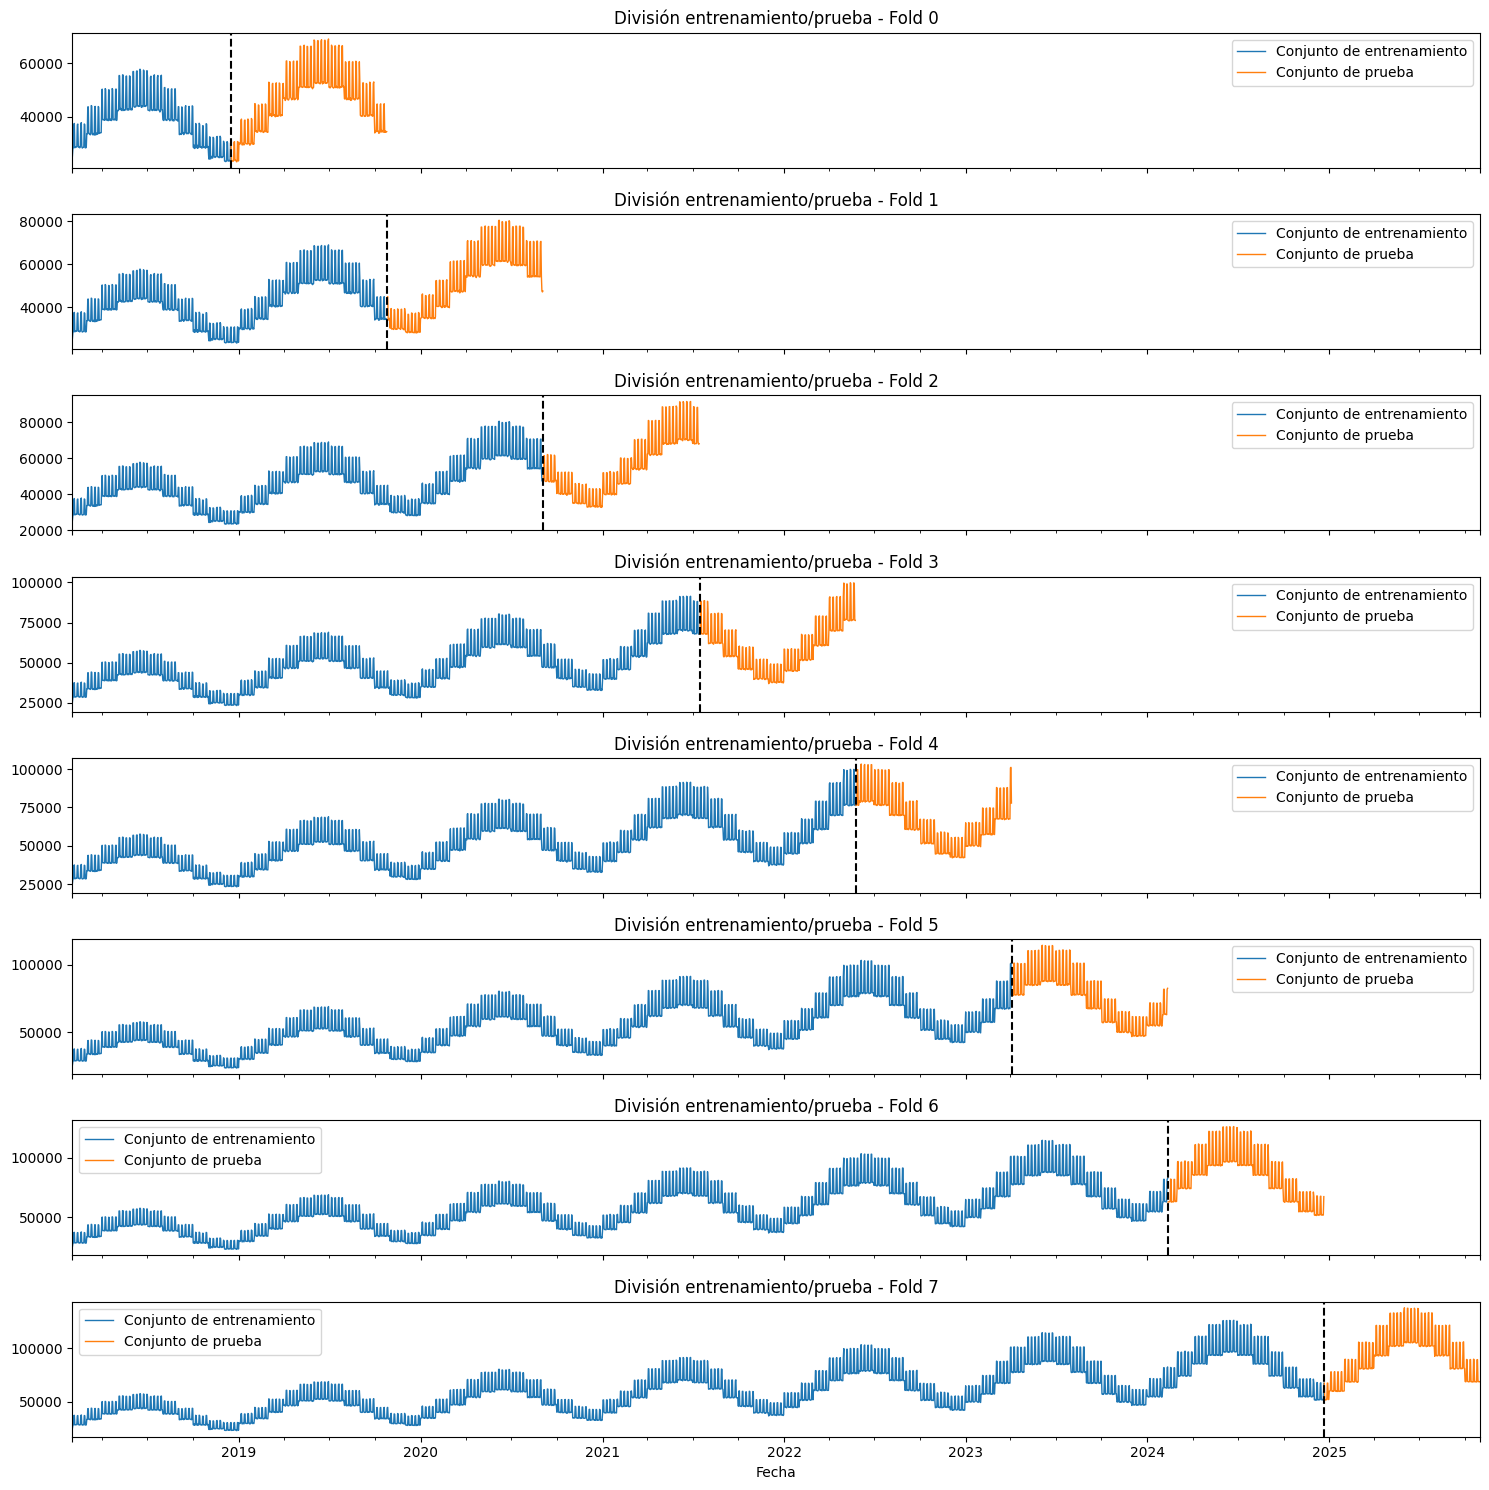


--- INICIO DE LA PREDICCIÓN A FUTURO ---

--- PREDICCIÓN FINAL DE VENTAS NETAS (Carne) ---
            Ventas_Netas_Predicha
Fecha                            
2025-11-01                81908.0
2025-11-02                81905.0
2025-11-03                66459.0
2025-11-04                66410.0
2025-11-05                66413.0
2025-11-06                66420.0
2025-11-07                66447.0


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error, r2_score 
from datetime import timedelta # Para manejo de fechas en la predicción

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---

# Carga de archivo (Asegúrate de que esta ruta sea correcta en tu máquina)
BASE    = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"

# Verificar que el archivo exista antes de cargarlo
if not ARCHIVO.exists():
    raise FileNotFoundError(f"¡ATENCIÓN! No se encontró el archivo en la ruta: {ARCHIVO}. Por favor, verifica la ubicación.")
    
print("Archivo encontrado. Cargando datos...")

# Carga
Df = pd.read_excel(ARCHIVO, sheet_name="DATA")

# Limpieza inicial y filtrado para el modelo de Carne
NewDf = Df.drop(["Transacciones_Count", "Ventas_Lag_7D", "Indicador_Economico_Local",
                "Gasto_Marketing_Dia", "Margen_Bruto"], axis=1)

NewDf["Fecha"] = pd.to_datetime(NewDf["Fecha"])
NewDf = NewDf[NewDf["Producto"] == "Carne"] # Filtramos solo para "Carne"
counts = NewDf.groupby("Fecha")["Ventas_Netas"].sum()
pw_clean = pd.DataFrame(counts)
pw_clean["Fecha"] = pd.to_datetime(pw_clean.index)
pw_clean = pw_clean.set_index("Fecha")

# --- 2. FUNCIONES DE INGENIERÍA DE ATRIBUTOS (FEATURE ENGINEERING) ---

def create_attributes(df): 
    """Crea atributos temporales (features) a partir del índice de fecha."""
    df = df.copy() 
    df['día'] = df.index.day 
    df['díadelasemana'] = df.index.dayofweek 
    df['mes'] = df.index.month 
    df['trimestre'] = df.index.quarter 
    df['año'] = df.index.year 
    df['díadelaño'] = df.index.dayofyear 
    return df 

def add_lag_features(df, target='Ventas_Netas', lags=[1, 7, 14, 30]):
    """Crea atributos de lag (retardo) y rolling mean."""
    df = df.copy()
    for lag in lags:
        # shift(1) asegura que el lag no incluya el valor actual (evitando data leakage)
        df[f'{target}_lag{lag}'] = df[target].shift(lag)
    df[f'{target}_rolling7']  = df[target].shift(1).rolling(7).mean()
    df[f'{target}_rolling30'] = df[target].shift(1).rolling(30).mean()
    return df

# Aplicar ingeniería de atributos a los datos
pw_clean = create_attributes(pw_clean)
pw_clean = add_lag_features(pw_clean)
pw_clean = pw_clean.dropna()

# Definición de features y target
features = ['día', 'díadelasemana', 'mes', 'trimestre', 'año', 'díadelaño',
            'Ventas_Netas_lag1', 'Ventas_Netas_lag7', 'Ventas_Netas_lag14', 'Ventas_Netas_lag30', 
            'Ventas_Netas_rolling7', 'Ventas_Netas_rolling30']
target = 'Ventas_Netas'


# --- 3. ENTRENAMIENTO Y VALIDACIÓN CON TIME SERIES SPLIT ---

pw_clean = pw_clean.sort_index()
ts_cv = TimeSeriesSplit(n_splits=8)

fold = 0
scores = []      # para RMSE
r2_scores = []   # para R-cuadrado

print("\n--- INICIO DEL ENTRENAMIENTO (8 Folds) ---")

for train_idx, val_idx in ts_cv.split(pw_clean):
    fold += 1
    train = pw_clean.iloc[train_idx].copy()
    test  = pw_clean.iloc[val_idx].copy()
    
    # Crear X e Y 
    x_train = train[features]
    y_train = train[target].values.ravel()  
    x_test  = test[features]
    y_test  = test[target].values.ravel()   

    # Hiperparámetros
    xgb_reg = xgb.XGBRegressor(
        booster='gbtree',
        random_state=42,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.3,  
        reg_lambda=0.001,
        objective='reg:squarederror',
        eval_metric='rmse',
    )
    
    # Entrenamiento con la sintaxis 'early_stopping_rounds' (Compatible con tu versión de XGBoost)
    xgb_reg.fit(
        x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=False
    )
    
    # Métricas
    y_pred = xgb_reg.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold} → RMSE: {rmse:,.0f} | R²: {r2:.4f}")


print("\n--- RESUMEN DE MÉTRICAS ---")
print(f"RMSE promedio: {np.mean(scores):,.0f}")
print(f"R² promedio: {np.mean(r2_scores):.4f}")

# Gráfico de las divisiones de TimeSeriesSplit 
fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True) 
fold = 0
for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test  = pw_clean.iloc[val_idx]

    train[target].plot(ax=axs[fold], lw=1, label="Conjunto de entrenamiento")
    test[target].plot(ax=axs[fold], lw=1, label="Conjunto de prueba")
    axs[fold].axvline(test.index.min(), color="black", ls="--") 
    axs[fold].set_title(f"División entrenamiento/prueba - Fold {fold}") 
    axs[fold].legend()
    fold += 1

plt.tight_layout()
plt.show()


# --- 4. PREDICCIÓN A FUTURO (Dinámica - 90 días) ---

print("\n--- INICIO DE LA PREDICCIÓN A FUTURO ---")

fecha_inicio_pred = pw_clean.index.max() + timedelta(days=1)
fecha_fin_pred = pw_clean.index.max() + timedelta(days=7) 

rango_fechas_futuro = pd.date_range(start=fecha_inicio_pred, end=fecha_fin_pred, freq='D')

df_futuro = pd.DataFrame(index=rango_fechas_futuro)
df_futuro.index.name = "Fecha"
df_futuro['Ventas_Netas'] = np.nan

df_completo = pd.concat([pw_clean[[target]], df_futuro])
df_completo.sort_index(inplace=True)

for current_date in rango_fechas_futuro:
    
    temp_df = df_completo.loc[:current_date].copy()
    temp_df = create_attributes(temp_df)
    temp_df = add_lag_features(temp_df)
    
    X_futuro_dia = temp_df.loc[current_date][features].to_frame().T
    
    y_pred_dia = xgb_reg.predict(X_futuro_dia)[0]
    
    df_completo.loc[current_date, 'Ventas_Netas'] = y_pred_dia

df_prediccion = df_completo.loc[rango_fechas_futuro].copy()
df_prediccion.rename(columns={'Ventas_Netas': 'Ventas_Netas_Predicha'}, inplace=True)

print("\n--- PREDICCIÓN FINAL DE VENTAS NETAS (Carne) ---")
print(df_prediccion[['Ventas_Netas_Predicha']].round(0))


Archivo encontrado. Cargando datos...

--- INICIO DEL ENTRENAMIENTO (8 Folds) ---
Fold 1 → RMSE: 5,170 | R²: 0.7766
Fold 2 → RMSE: 5,527 | R²: 0.8568
Fold 3 → RMSE: 5,072 | R²: 0.8982
Fold 4 → RMSE: 4,103 | R²: 0.9263
Fold 5 → RMSE: 6,663 | R²: 0.8258
Fold 6 → RMSE: 5,431 | R²: 0.9134
Fold 7 → RMSE: 5,462 | R²: 0.9213
Fold 8 → RMSE: 7,396 | R²: 0.8770

--- RESUMEN DE MÉTRICAS ---
RMSE promedio: 5,603
R² promedio: 0.8744


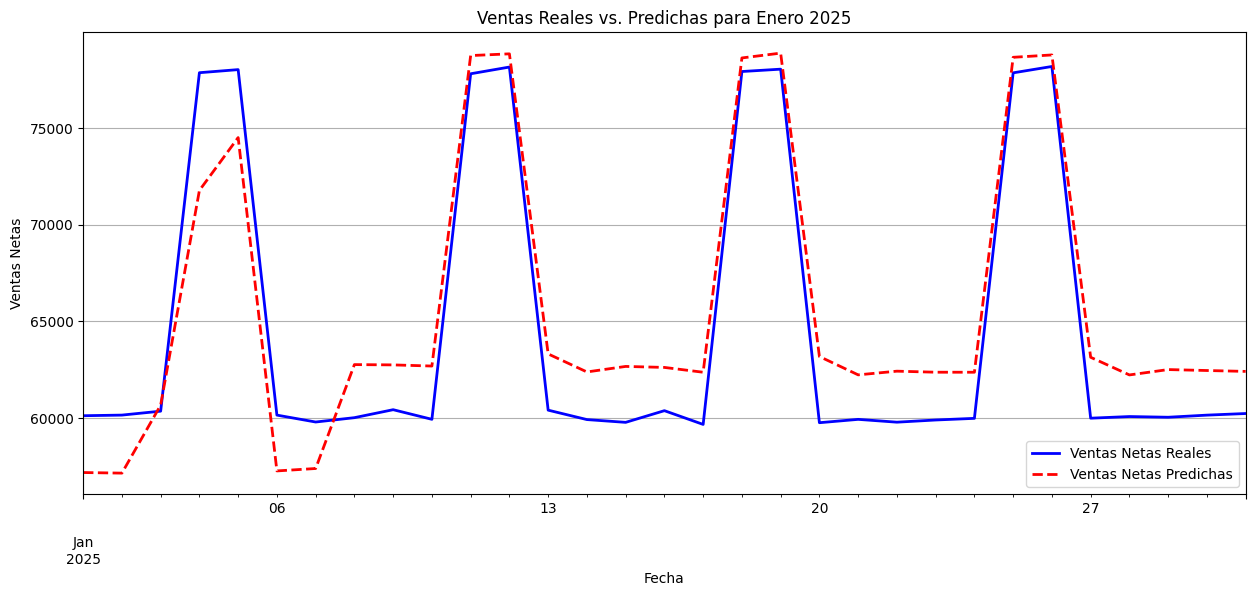

Advertencia: El último conjunto de prueba no contiene datos de Enero de 2025. Ajuste el rango de n_splits.


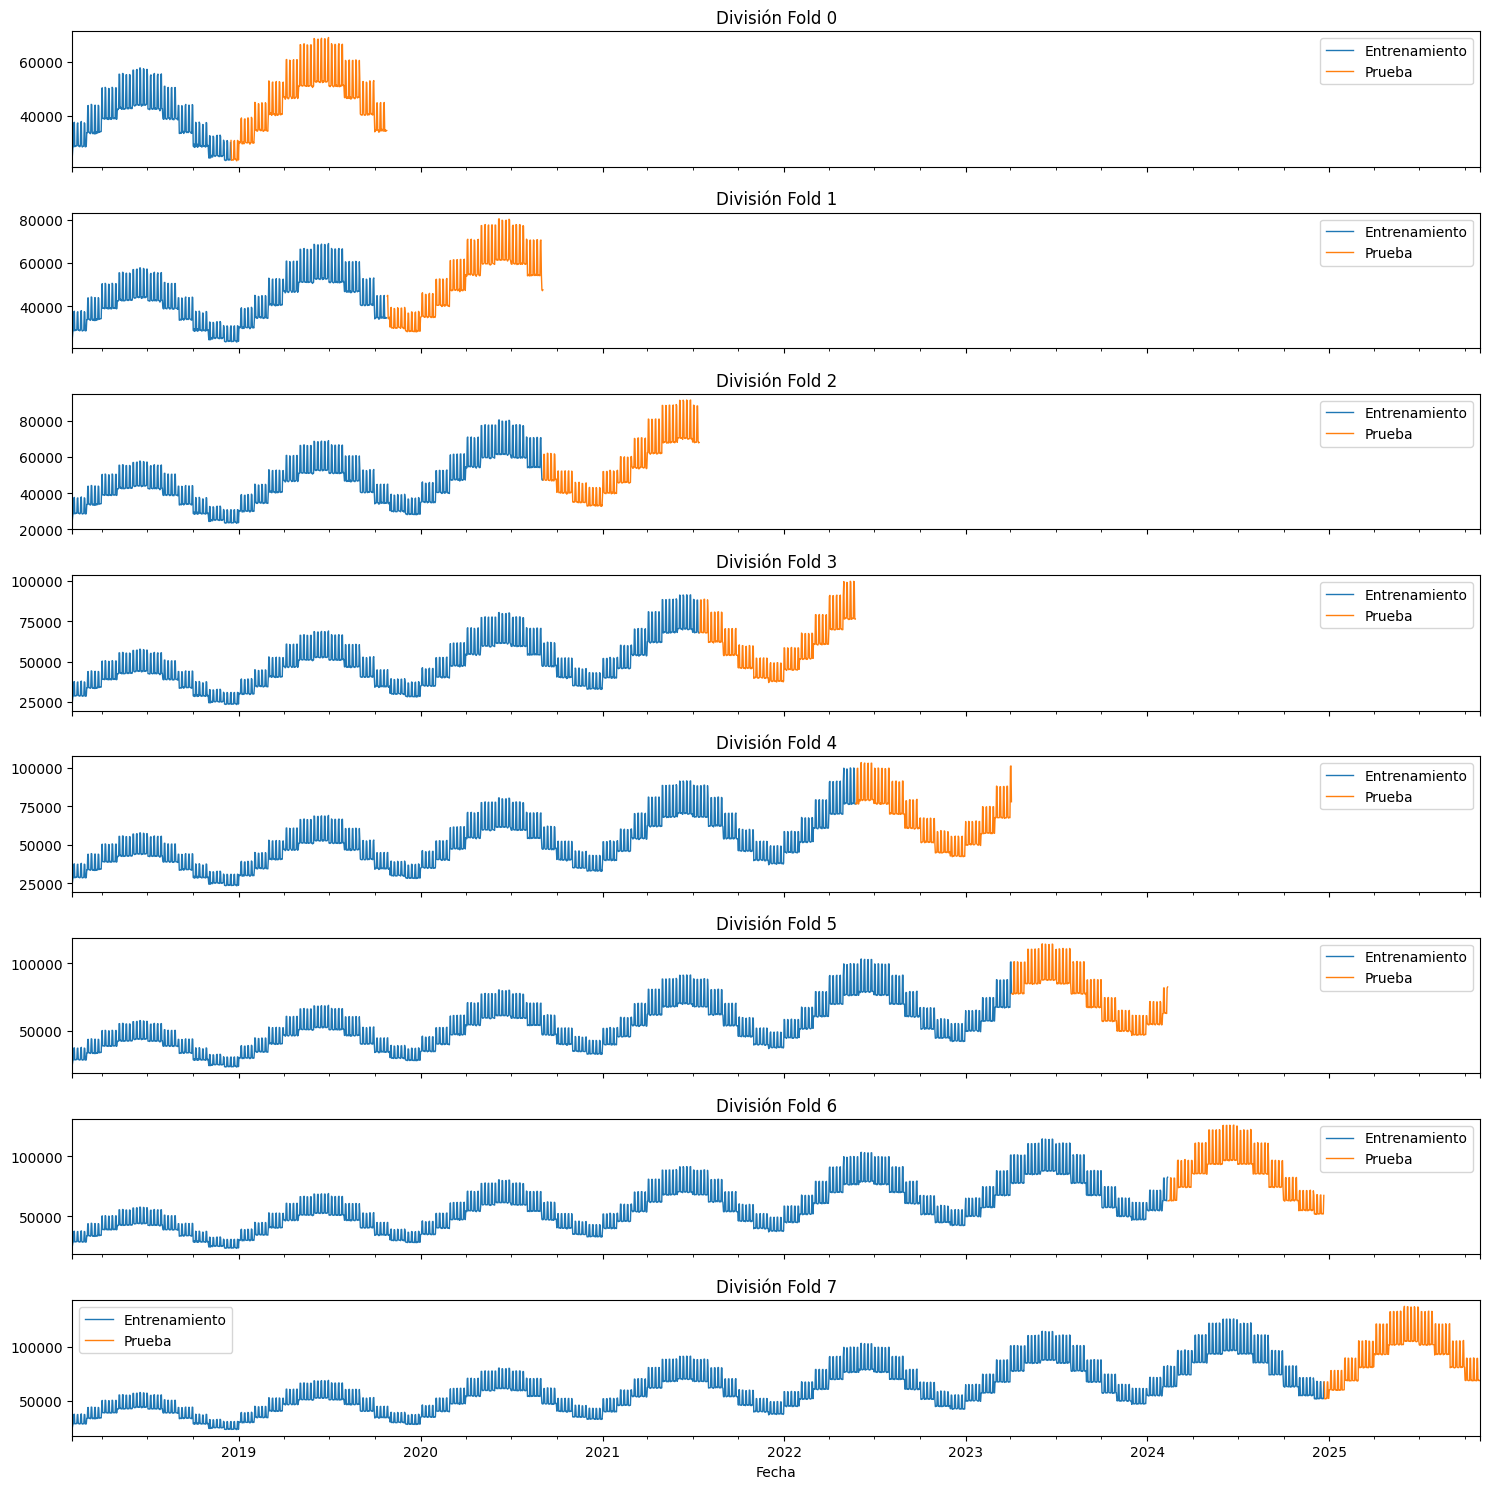

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error, r2_score 
from datetime import timedelta 

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---

BASE    = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"

if not ARCHIVO.exists():
    raise FileNotFoundError(f"¡ATENCIÓN! No se encontró el archivo en la ruta: {ARCHIVO}. Por favor, verifica la ubicación.")
    
print("Archivo encontrado. Cargando datos...")

Df = pd.read_excel(ARCHIVO, sheet_name="DATA")

# Limpieza y filtrado
NewDf = Df.drop(["Transacciones_Count", "Ventas_Lag_7D", "Indicador_Economico_Local",
                "Gasto_Marketing_Dia", "Margen_Bruto"], axis=1)

NewDf["Fecha"] = pd.to_datetime(NewDf["Fecha"])
NewDf = NewDf[NewDf["Producto"] == "Carne"] 
counts = NewDf.groupby("Fecha")["Ventas_Netas"].sum()
pw_clean = pd.DataFrame(counts)
pw_clean["Fecha"] = pd.to_datetime(pw_clean.index)
pw_clean = pw_clean.set_index("Fecha")

# --- 2. FUNCIONES DE INGENIERÍA DE ATRIBUTOS (FEATURE ENGINEERING) ---

def create_attributes(df): 
    """Crea atributos temporales (features) a partir del índice de fecha."""
    df = df.copy() 
    df['día'] = df.index.day 
    df['díadelasemana'] = df.index.dayofweek 
    df['mes'] = df.index.month 
    df['trimestre'] = df.index.quarter 
    df['año'] = df.index.year 
    df['díadelaño'] = df.index.dayofyear 
    return df 

def add_lag_features(df, target='Ventas_Netas', lags=[1, 7, 14, 30]):
    """Crea atributos de lag (retardo) y rolling mean."""
    df = df.copy()
    for lag in lags:
        df[f'{target}_lag{lag}'] = df[target].shift(lag)
    df[f'{target}_rolling7']  = df[target].shift(1).rolling(7).mean()
    df[f'{target}_rolling30'] = df[target].shift(1).rolling(30).mean()
    return df

# Aplicar ingeniería de atributos
pw_clean = create_attributes(pw_clean)
pw_clean = add_lag_features(pw_clean)
pw_clean = pw_clean.dropna()

features = ['día', 'díadelasemana', 'mes', 'trimestre', 'año', 'díadelaño',
            'Ventas_Netas_lag1', 'Ventas_Netas_lag7', 'Ventas_Netas_lag14', 'Ventas_Netas_lag30', 
            'Ventas_Netas_rolling7', 'Ventas_Netas_rolling30']
target = 'Ventas_Netas'


# --- 3. ENTRENAMIENTO Y VALIDACIÓN CON TIME SERIES SPLIT ---

pw_clean = pw_clean.sort_index()
ts_cv = TimeSeriesSplit(n_splits=8)

fold = 0
scores = []      
r2_scores = []   
last_test = None 
xgb_reg = None   

print("\n--- INICIO DEL ENTRENAMIENTO (8 Folds) ---")

for train_idx, val_idx in ts_cv.split(pw_clean):
    fold += 1
    train = pw_clean.iloc[train_idx].copy()
    test  = pw_clean.iloc[val_idx].copy()
    
    # Crear X e Y 
    x_train = train[features]
    y_train = train[target].values.ravel()  
    x_test  = test[features]
    y_test  = test[target].values.ravel()   

    # Hiperparámetros (Aquí usamos la misma configuración)
    xgb_reg = xgb.XGBRegressor(
        booster='gbtree',
        random_state=42,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.3,  
        reg_lambda=0.001,
        objective='reg:squarederror',
        eval_metric='rmse',
    )
    
    # Entrenamiento 
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
    
    # Métricas y Predicción
    y_pred = xgb_reg.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold} → RMSE: {rmse:,.0f} | R²: {r2:.4f}")
    
    # --- Guardar el resultado del último Fold (Enero 2025) para visualización ---
    if fold == ts_cv.n_splits:
        last_test = test.copy()
        last_test['Ventas_Predicha'] = y_pred

print("\n--- RESUMEN DE MÉTRICAS ---")
print(f"RMSE promedio: {np.mean(scores):,.0f}")
print(f"R² promedio: {np.mean(r2_scores):.4f}")


# --- 3.1. VISUALIZACIÓN DE LA PREDICCIÓN VS. REAL (ÚLTIMO TEST SET: Enero 2025) ---

if last_test is not None:
    plt.figure(figsize=(15, 6))
    
    data_enero_2025 = last_test[last_test.index.to_period('M') == '2025-01']
    
    if not data_enero_2025.empty:
        # 1. Plotear los valores reales
        data_enero_2025[target].plot(
            label='Ventas Netas Reales', 
            color='blue', 
            linewidth=2
        )
        
        # 2. Plotear los valores predichos
        data_enero_2025['Ventas_Predicha'].plot(
            label='Ventas Netas Predichas', 
            color='red', 
            linestyle='--', 
            linewidth=2
        )
        
        plt.title('Ventas Reales vs. Predichas para Enero Carne 2025')
        plt.xlabel('Fecha')
        plt.ylabel('Ventas Netas')
        plt.grid(True)
        plt.legend()
        plt.show() #     else:
        print("Advertencia: El último conjunto de prueba no contiene datos de Enero de 2025. Ajuste el rango de n_splits.")


# Gráfico de las divisiones de TimeSeriesSplit 
# (Este gráfico es solo informativo, muestra cómo se dividieron los datos)
fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True) 
fold = 0
for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test  = pw_clean.iloc[val_idx]
    train[target].plot(ax=axs[fold], lw=1, label="Entrenamiento")
    test[target].plot(ax=axs[fold], lw=1, label="Prueba")
    axs[fold].set_title(f"División Fold {fold}") 
    axs[fold].legend()
    fold += 1
plt.tight_layout()
plt.show()



Archivo encontrado. Cargando datos...

--- INICIO DEL ENTRENAMIENTO (8 Folds) ---
Fold 1 → RMSE: 3,465 | R²: 0.7756
Fold 2 → RMSE: 3,858 | R²: 0.8430
Fold 3 → RMSE: 3,807 | R²: 0.8712
Fold 4 → RMSE: 2,435 | R²: 0.9414
Fold 5 → RMSE: 4,490 | R²: 0.8210
Fold 6 → RMSE: 3,791 | R²: 0.9049
Fold 7 → RMSE: 4,050 | R²: 0.9026
Fold 8 → RMSE: 5,038 | R²: 0.8714

--- RESUMEN DE MÉTRICAS ---
RMSE promedio: 3,867
R² promedio: 0.8664


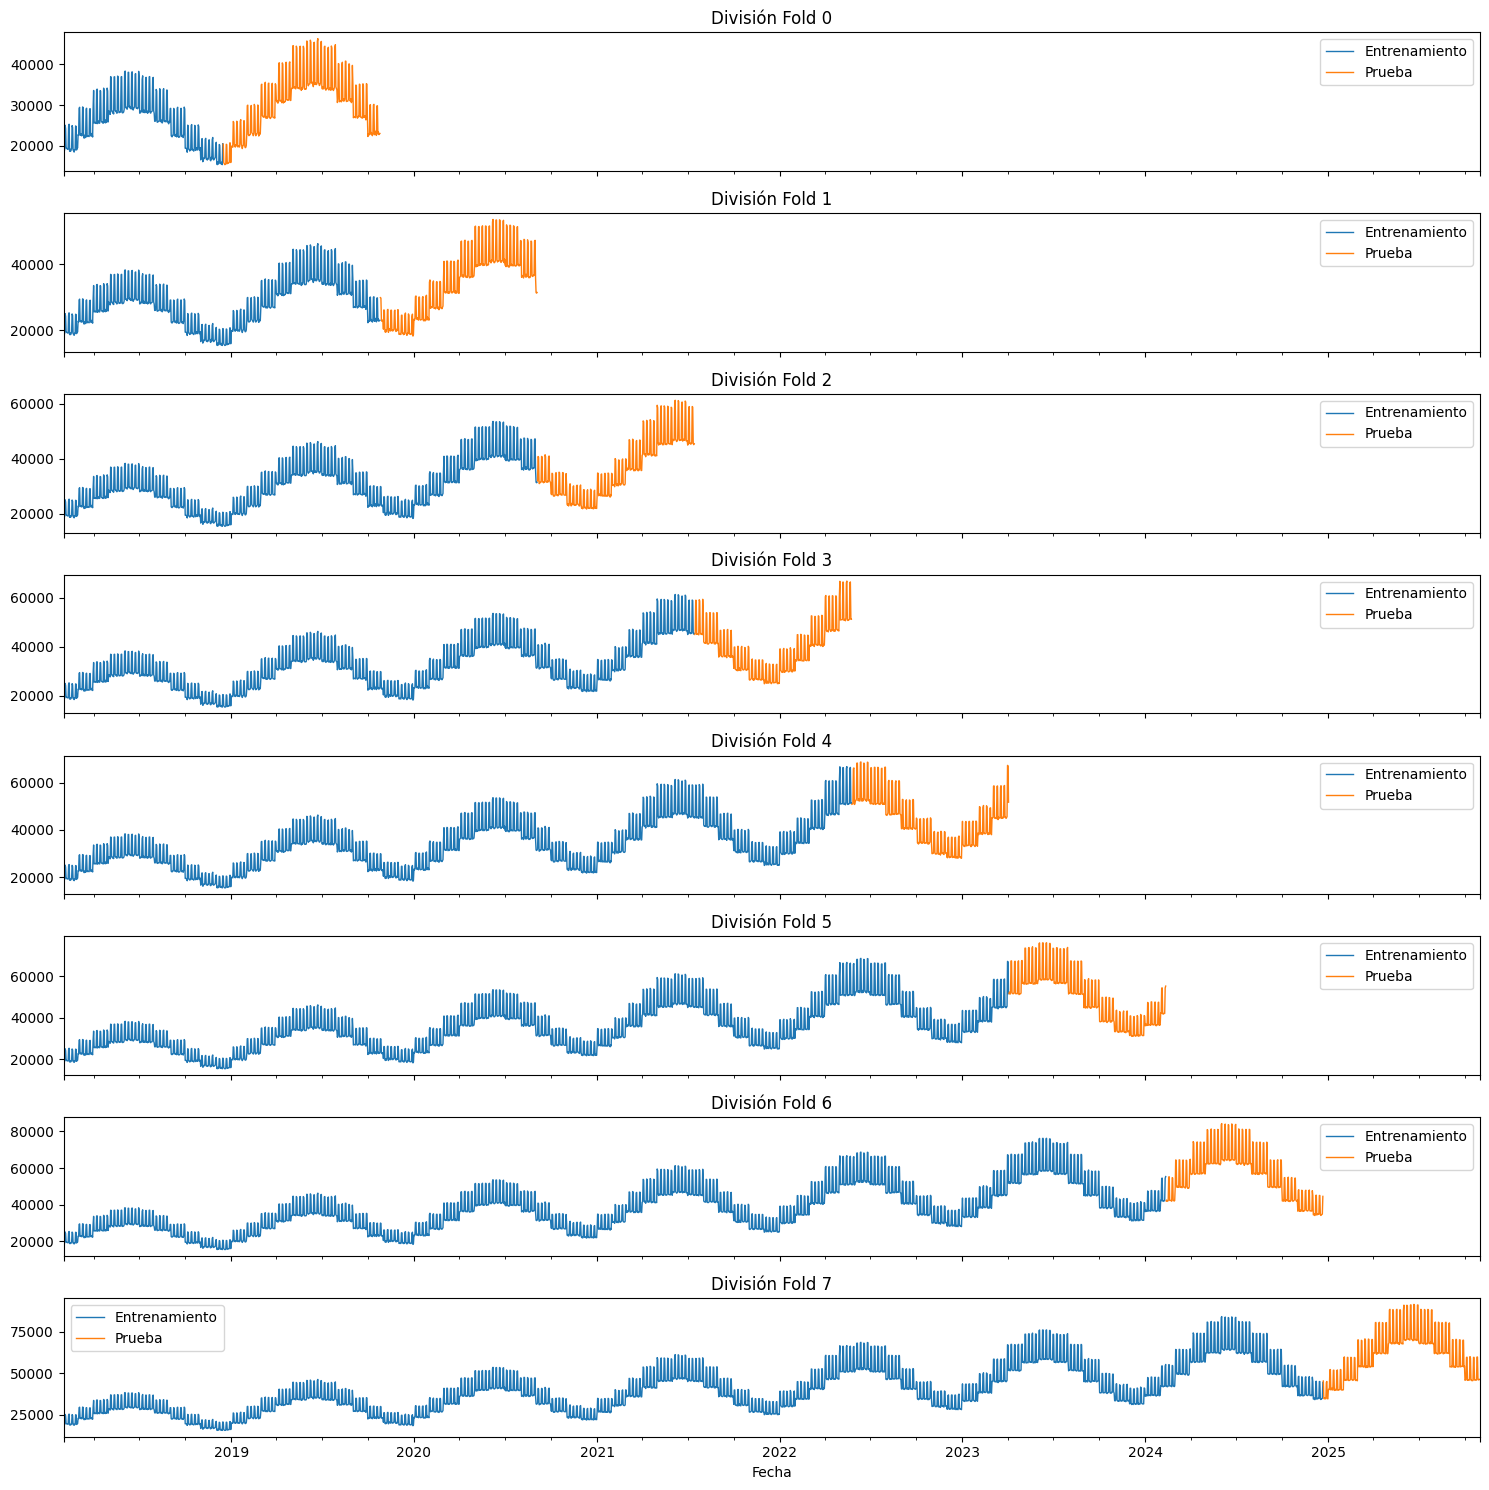

Modelo y datos guardados para la App.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Lo mantenemos por si quieres usar el gráfico de splits
import plotly.graph_objects as go # Importación de Plotly
from plotly.subplots import make_subplots
import xgboost as xgb
from xgboost import XGBRegressor
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit 
from sklearn.metrics import mean_squared_error, r2_score 
from datetime import timedelta 

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---

BASE    = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"

if not ARCHIVO.exists():
    raise FileNotFoundError(f"¡ATENCIÓN! No se encontró el archivo en la ruta: {ARCHIVO}. Por favor, verifica la ubicación.")
    
print("Archivo encontrado. Cargando datos...")

Df = pd.read_excel(ARCHIVO, sheet_name="DATA")

# Limpieza y filtrado
NewDf = Df.drop(["Transacciones_Count", "Ventas_Lag_7D", "Indicador_Economico_Local",
                "Gasto_Marketing_Dia", "Margen_Bruto"], axis=1)

NewDf["Fecha"] = pd.to_datetime(NewDf["Fecha"])
NewDf = NewDf[NewDf["Producto"] == "Pollo"] 
counts = NewDf.groupby("Fecha")["Ventas_Netas"].sum()
pw_clean = pd.DataFrame(counts)
pw_clean["Fecha"] = pd.to_datetime(pw_clean.index)
pw_clean = pw_clean.set_index("Fecha")

# --- 2. FUNCIONES DE INGENIERÍA DE ATRIBUTOS (FEATURE ENGINEERING) ---

def create_attributes(df): 
    """Crea atributos temporales (features) a partir del índice de fecha."""
    df = df.copy() 
    df['día'] = df.index.day 
    df['díadelasemana'] = df.index.dayofweek 
    df['mes'] = df.index.month 
    df['trimestre'] = df.index.quarter 
    df['año'] = df.index.year 
    df['díadelaño'] = df.index.dayofyear 
    return df 

def add_lag_features(df, target='Ventas_Netas', lags=[1, 7, 14, 30]):
    """Crea atributos de lag (retardo) y rolling mean."""
    df = df.copy()
    for lag in lags:
        df[f'{target}_lag{lag}'] = df[target].shift(lag)
    df[f'{target}_rolling7']  = df[target].shift(1).rolling(7).mean()
    df[f'{target}_rolling30'] = df[target].shift(1).rolling(30).mean()
    return df

# Aplicar ingeniería de atributos
pw_clean = create_attributes(pw_clean)
pw_clean = add_lag_features(pw_clean)
pw_clean = pw_clean.dropna()

features = ['día', 'díadelasemana', 'mes', 'trimestre', 'año', 'díadelaño',
            'Ventas_Netas_lag1', 'Ventas_Netas_lag7', 'Ventas_Netas_lag14', 'Ventas_Netas_lag30', 
            'Ventas_Netas_rolling7', 'Ventas_Netas_rolling30']
target = 'Ventas_Netas'


# --- 3. ENTRENAMIENTO Y VALIDACIÓN CON TIME SERIES SPLIT ---

pw_clean = pw_clean.sort_index()
ts_cv = TimeSeriesSplit(n_splits=8)

fold = 0
scores = []      
r2_scores = []   
last_test = None 
xgb_reg = None   

print("\n--- INICIO DEL ENTRENAMIENTO (8 Folds) ---")

for train_idx, val_idx in ts_cv.split(pw_clean):
    fold += 1
    train = pw_clean.iloc[train_idx].copy()
    test  = pw_clean.iloc[val_idx].copy()
    
    # Crear X e Y 
    x_train = train[features]
    y_train = train[target].values.ravel()  
    x_test  = test[features]
    y_test  = test[target].values.ravel()   

    # Hiperparámetros
    xgb_reg = xgb.XGBRegressor(
        booster='gbtree',
        random_state=42,
        n_estimators=1000,
        max_depth=12,
        learning_rate=0.3,  
        reg_lambda=0.001,
        objective='reg:squarederror',
        eval_metric='rmse',
    )
    
    # Entrenamiento 
    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=False)
    
    # Métricas y Predicción
    y_pred = xgb_reg.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    scores.append(rmse)
    r2_scores.append(r2)
    
    print(f"Fold {fold} → RMSE: {rmse:,.0f} | R²: {r2:.4f}")
    
    # --- Guardar el resultado del último Fold (contiene Enero 2025) ---
    if fold == ts_cv.n_splits:
        last_test = test.copy()
        last_test['Ventas_Predicha'] = y_pred

print("\n--- RESUMEN DE MÉTRICAS ---")
print(f"RMSE promedio: {np.mean(scores):,.0f}")
print(f"R² promedio: {np.mean(r2_scores):.4f}")


# --- 3.1. VISUALIZACIÓN INTERACTIVA DE LA PREDICCIÓN VS. REAL (PLOTLY) ---

if last_test is not None:
    # 1. Filtrar solo Enero de 2025
    data_enero_2025 = last_test[last_test.index.to_period('M') == '2025-01']
    
    if not data_enero_2025.empty:
        
        # Crear la figura de Plotly
        fig = go.Figure()
        
        # Traza 1: Valores Reales (Línea Sólida Azul)
        fig.add_trace(go.Scatter(
            x=data_enero_2025.index, 
            y=data_enero_2025[target],
            mode='lines',
            name='Ventas Netas Reales',
            line=dict(color='blue', width=2)
        ))
        
        # Traza 2: Valores Predichos (Línea Discontinua Roja)
        fig.add_trace(go.Scatter(
            x=data_enero_2025.index, 
            y=data_enero_2025['Ventas_Predicha'],
            mode='lines',
            name='Ventas Netas Predichas',
            line=dict(color='red', dash='dash', width=2)
        ))
        
        # Actualizar el layout para un título y etiquetas claras
        fig.update_layout(
            title='Ventas Reales vs. Predichas para Enero Pollo 2025',
            xaxis_title='Fecha',
            yaxis_title='Ventas Netas',
            hovermode="x unified", # Muestra los valores de ambas líneas en un solo hover
            template="plotly_white"
        )
        
        # Mostrar el gráfico interactivo
        fig.show()
    else:
        print("Advertencia: El último conjunto de prueba no contiene datos de Enero de 2025.")


# Gráfico de las divisiones de TimeSeriesSplit (se mantiene en Matplotlib)
fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True) 
fold = 0
for train_idx, val_idx in ts_cv.split(pw_clean):
    train = pw_clean.iloc[train_idx]
    test  = pw_clean.iloc[val_idx]
    train[target].plot(ax=axs[fold], lw=1, label="Entrenamiento")
    test[target].plot(ax=axs[fold], lw=1, label="Prueba")
    axs[fold].set_title(f"División Fold {fold}") 
    axs[fold].legend()
    fold += 1
plt.tight_layout()
plt.show()

# Al final de tu código de Jupyter:
import pickle

# Guardar el modelo
with open('modelo_ventas.sav', 'wb') as f:
    pickle.dump(xgb_reg, f)

# IMPORTANTE: Guarda también los últimos datos para que Flask pueda calcular los "Lags"
pw_clean.tail(60).to_csv("ultimos_datos.csv") 
print("Modelo y datos guardados para la App.")
# --- EXPORTAR RESULTADOS A EXCEL (Fecha, Real, Predicho) ---



In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import xgboost as xgb
from pathlib import Path
from datetime import timedelta

# --- 1. CARGA Y PREPARACIÓN ---
BASE = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"

Df = pd.read_excel(ARCHIVO, sheet_name="DATA")
NewDf = Df.copy()
NewDf["Fecha"] = pd.to_datetime(NewDf["Fecha"])
NewDf = NewDf[NewDf["Producto"] == "Pollo"] 
pw_clean = NewDf.groupby("Fecha")["Ventas_Netas"].sum().to_frame()
pw_clean.sort_index(inplace=True)

def create_features(df):
    df = df.copy()
    df['día'] = df.index.day
    df['díadelasemana'] = df.index.dayofweek
    df['mes'] = df.index.month
    df['trimestre'] = df.index.quarter
    df['año'] = df.index.year
    df['díadelaño'] = df.index.dayofyear
    return df

def add_lags(df):
    df = df.copy()
    for lag in [1, 7, 14, 30]:
        df[f'Ventas_Netas_lag{lag}'] = df['Ventas_Netas'].shift(lag)
    df['Ventas_Netas_rolling7']  = df['Ventas_Netas'].shift(1).rolling(7).mean()
    df['Ventas_Netas_rolling30'] = df['Ventas_Netas'].shift(1).rolling(30).mean()
    return df

features = ['día', 'díadelasemana', 'mes', 'trimestre', 'año', 'díadelaño',
            'Ventas_Netas_lag1', 'Ventas_Netas_lag7', 'Ventas_Netas_lag14', 'Ventas_Netas_lag30', 
            'Ventas_Netas_rolling7', 'Ventas_Netas_rolling30']

# --- 3. DIVISIÓN DE DATOS Y ENTRENAMIENTO ---
# Preparamos toda la data con lags
full_data = add_lags(create_features(pw_clean)).dropna()

train_data = full_data[full_data.index < '2025-01-01']
test_data = full_data[full_data.index >= '2025-01-01']

xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.3, random_state=42)
xgb_reg.fit(train_data[features], train_data['Ventas_Netas'])

# Predicciones para la gráfica
train_preds = xgb_reg.predict(train_data[features])
test_preds = xgb_reg.predict(test_data[features])

# --- 4. PROYECCIÓN FUTURA (NOVIEMBRE 2025) ---
df_proy = pw_clean.copy()
ultima_fecha_real = pw_clean.index.max()

for _ in range(30):
    nueva_fecha = df_proy.index.max() + timedelta(days=1)
    df_proy.loc[nueva_fecha, 'Ventas_Netas'] = np.nan
    
    temp = add_lags(create_features(df_proy))
    X_f = temp.loc[[nueva_fecha], features]
    
    pred = xgb_reg.predict(X_f)[0]
    df_proy.loc[nueva_fecha, 'Ventas_Netas'] = max(0, pred)

proyeccion_nov = df_proy.loc[df_proy.index > ultima_fecha_real].copy()

# --- 5. GRÁFICA PROFESIONAL ---
fig = go.Figure()

# 1. Historia Real (Todo lo que está en el Excel)
fig.add_trace(go.Scatter(x=pw_clean.index, y=pw_clean['Ventas_Netas'],
                         name='Venta Real', line=dict(color='silver', width=1.5)))

# 2. Ajuste de Entrenamiento (Hasta Dic 2024)
fig.add_trace(go.Scatter(x=train_data.index, y=train_preds,
                         name='Ajuste Entrenamiento (Pre-2025)', line=dict(color='blue', width=1, dash='dot')))

# 3. Testeo / Validación (Enero - Octubre 2025)
# Conectamos con el último punto de entrenamiento para que sea continua
fig.add_trace(go.Scatter(x=test_data.index, y=test_preds,
                         name='Validación (Test 2025)', line=dict(color='red', width=2)))


ultimo_real = pw_clean.tail(1)
x_p = pd.concat([ultimo_real.index.to_series(), proyeccion_nov.index.to_series()])
y_p = pd.concat([ultimo_real['Ventas_Netas'], proyeccion_nov['Ventas_Netas']])

fig.add_trace(go.Scatter(x=x_p, y=y_p,
                         name='Proyección (Noviembre 2025)', line=dict(color='green', width=4)))

# Configuración de Layout
fig.update_layout(
    title="Pollo: Historia, Validación 2025 y Proyección Noviembre",
    xaxis_title="Fecha", yaxis_title="Ventas Netas",
    template="plotly_white", hovermode="x unified"
)


fig.show()
# --- 7. CONSOLIDACIÓN Y EXPORTACIÓN A EXCEL ---
df_export = pw_clean.copy()
df_export.columns = ['Venta_Real']

df_export.loc[train_data.index, 'Entrenamiento_Ajuste'] = train_preds

df_export.loc[test_data.index, 'Validacion_Test_2025'] = test_preds

# 4. Agregamos la proyección de Noviembre (El futuro)
for fecha_f in proyeccion_nov.index:
    df_export.loc[fecha_f, 'Proyeccion_Noviembre'] = proyeccion_nov.loc[fecha_f, 'Ventas_Netas']

df_export = df_export.round(0)

nombre_final_excel = "Analisis_Final_Ventas_Pollo.xlsx"
df_export.to_excel(nombre_final_excel, index_label='Fecha')

print(f"\Excel generado con éxito")
print(f"📁 Nombre: {nombre_final_excel}")
print(f"Columnas incluidas: Venta_Real, Entrenamiento_Ajuste, Validacion_Test_2025, Proyeccion_Noviembre")
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(xgb_reg, f)

<>:121: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
<>:121: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
/var/folders/qk/0z7ssbdx0bjcfhshhz_p01_h0000gn/T/ipykernel_60506/454240570.py:121: SyntaxWarning: "\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.
  print(f"\Excel generado con éxito")


\Excel generado con éxito
📁 Nombre: Analisis_Final_Ventas_Pollo.xlsx
Columnas incluidas: Venta_Real, Entrenamiento_Ajuste, Validacion_Test_2025, Proyeccion_Noviembre


In [23]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import xgboost as xgb
from pathlib import Path
from datetime import timedelta

# --- 1. CARGA Y PREPARACIÓN ---
BASE = Path(r"/Users/juanbarcenas/Documents/Proyecto Fourgeeks")
ARCHIVO = BASE / "ventas_diarias_carne_pollo_143k_filas.xlsx"

Df = pd.read_excel(ARCHIVO, sheet_name="DATA")
NewDf = Df.copy()
NewDf["Fecha"] = pd.to_datetime(NewDf["Fecha"])
NewDf = NewDf[NewDf["Producto"] == "Carne"] 
pw_clean = NewDf.groupby("Fecha")["Ventas_Netas"].sum().to_frame()
pw_clean.sort_index(inplace=True)

def create_features(df):
    df = df.copy()
    df['día'] = df.index.day
    df['díadelasemana'] = df.index.dayofweek
    df['mes'] = df.index.month
    df['trimestre'] = df.index.quarter
    df['año'] = df.index.year
    df['díadelaño'] = df.index.dayofyear
    return df

def add_lags(df):
    df = df.copy()
    for lag in [1, 7, 14, 30]:
        df[f'Ventas_Netas_lag{lag}'] = df['Ventas_Netas'].shift(lag)
    df['Ventas_Netas_rolling7']  = df['Ventas_Netas'].shift(1).rolling(7).mean()
    df['Ventas_Netas_rolling30'] = df['Ventas_Netas'].shift(1).rolling(30).mean()
    return df

features = ['día', 'díadelasemana', 'mes', 'trimestre', 'año', 'díadelaño',
            'Ventas_Netas_lag1', 'Ventas_Netas_lag7', 'Ventas_Netas_lag14', 'Ventas_Netas_lag30', 
            'Ventas_Netas_rolling7', 'Ventas_Netas_rolling30']

# --- 3. DIVISIÓN DE DATOS Y ENTRENAMIENTO ---
# Preparamos toda la data con lags
full_data = add_lags(create_features(pw_clean)).dropna()

train_data = full_data[full_data.index < '2025-01-01']
test_data = full_data[full_data.index >= '2025-01-01']

xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.3, random_state=42)
xgb_reg.fit(train_data[features], train_data['Ventas_Netas'])

# Predicciones para la gráfica
train_preds = xgb_reg.predict(train_data[features])
test_preds = xgb_reg.predict(test_data[features])

# --- 4. PROYECCIÓN FUTURA (NOVIEMBRE 2025) ---
df_proy = pw_clean.copy()
ultima_fecha_real = pw_clean.index.max()

for _ in range(30):
    nueva_fecha = df_proy.index.max() + timedelta(days=1)
    df_proy.loc[nueva_fecha, 'Ventas_Netas'] = np.nan
    
    temp = add_lags(create_features(df_proy))
    X_f = temp.loc[[nueva_fecha], features]
    
    pred = xgb_reg.predict(X_f)[0]
    df_proy.loc[nueva_fecha, 'Ventas_Netas'] = max(0, pred)

proyeccion_nov = df_proy.loc[df_proy.index > ultima_fecha_real].copy()

# --- 5. GRÁFICA PROFESIONAL ---
fig = go.Figure()

# 1. Historia Real (Todo lo que está en el Excel)
fig.add_trace(go.Scatter(x=pw_clean.index, y=pw_clean['Ventas_Netas'],
                         name='Venta Real', line=dict(color='silver', width=1.5)))

# 2. Ajuste de Entrenamiento (Hasta Dic 2024)
fig.add_trace(go.Scatter(x=train_data.index, y=train_preds,
                         name='Ajuste Entrenamiento (Pre-2025)', line=dict(color='blue', width=1, dash='dot')))

# 3. Testeo / Validación (Enero - Octubre 2025)
# Conectamos con el último punto de entrenamiento para que sea continua
fig.add_trace(go.Scatter(x=test_data.index, y=test_preds,
                         name='Validación (Test 2025)', line=dict(color='red', width=2)))


ultimo_real = pw_clean.tail(1)
x_p = pd.concat([ultimo_real.index.to_series(), proyeccion_nov.index.to_series()])
y_p = pd.concat([ultimo_real['Ventas_Netas'], proyeccion_nov['Ventas_Netas']])

fig.add_trace(go.Scatter(x=x_p, y=y_p,
                         name='Proyección (Noviembre 2025)', line=dict(color='green', width=4)))

# Configuración de Layout
fig.update_layout(
    title="Carne: Historia, Validación 2025 y Proyección Noviembre",
    xaxis_title="Fecha", yaxis_title="Ventas Netas",
    template="plotly_white", hovermode="x unified"
)


fig.show()
# --- 7. CONSOLIDACIÓN Y EXPORTACIÓN A EXCEL ---
df_export = pw_clean.copy()
df_export.columns = ['Venta_Real']

df_export.loc[train_data.index, 'Entrenamiento_Ajuste'] = train_preds

df_export.loc[test_data.index, 'Validacion_Test_2025'] = test_preds

# 4. Agregamos la proyección de Noviembre (El futuro)
for fecha_f in proyeccion_nov.index:
    df_export.loc[fecha_f, 'Proyeccion_Noviembre'] = proyeccion_nov.loc[fecha_f, 'Ventas_Netas']

df_export = df_export.round(0)

nombre_final_excel = "Analisis_Final_Ventas_Pollo.xlsx"
df_export.to_excel(nombre_final_excel, index_label='Fecha')

print(f"\Excel generado con éxito")
print(f"📁 Nombre: {nombre_final_excel}")
print(f"Columnas incluidas: Venta_Real, Entrenamiento_Ajuste, Validacion_Test_2025, Proyeccion_Noviembre")

<>:121: SyntaxWarning:

"\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.

<>:121: SyntaxWarning:

"\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.

/var/folders/qk/0z7ssbdx0bjcfhshhz_p01_h0000gn/T/ipykernel_8409/3485213809.py:121: SyntaxWarning:

"\E" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\E"? A raw string is also an option.



\Excel generado con éxito
📁 Nombre: Analisis_Final_Ventas_Pollo.xlsx
Columnas incluidas: Venta_Real, Entrenamiento_Ajuste, Validacion_Test_2025, Proyeccion_Noviembre
